In [ ]:
!pip install pytorch-lightning==2.0.0

In [ ]:
from google.colab import files
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import torch

from torch.nn.utils.rnn import pad_sequence
from pytorch_lightning import Trainer
from torch.utils.data import Dataset
import pandas as pd
import random
import csv
import torch
import torch.nn as nn
import pytorch_lightning as pl
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning.loggers import CSVLogger



# loding the data to colab notebook with global norm
VICON means: {'x': -0.43115391465428127, 'y': -5.197877091293594, 'z': 0.8225721439482224}
VICON stds: {'x': 7.031621700327482, 'y': 3.7762701144669895, 'z': 4.301736863121226}
Smartwatch means: {'x': -0.1677919570892769, 'y': -0.29380321094635525, 'z': 0.5839521319128307}
Smartwatch stds: {'x': 0.6465784907068888, 'y': 0.8770548363685408, 'z': 0.4133581988871836}
Normalization complete.

In [ ]:
!pip install kaggle
files.upload()
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c bgu-i-cant-see-you-but-you-are-reading-a-book

os.makedirs("data_experiment", exist_ok=True)  # Create a folder named 'data'
!unzip bgu-i-cant-see-you-but-you-are-reading-a-book.zip -d data_experiment/

without calculations

In [ ]:
# Define source and output directories
source_dir = '/content/data_experiment/unlabeled/unlabeled/'
vicon_dir = '/content/data_experiment/vicon/'
smartwatch_dir = '/content/data_experiment/smartwatch/'

# Path to train.csv
train_csv_path = '/content/data_experiment/train.csv'

# Create output directories
os.makedirs(vicon_dir, exist_ok=True)
os.makedirs(smartwatch_dir, exist_ok=True)

# Load train.csv
train_df = pd.read_csv(train_csv_path)

# Predefined standardization values
vicon_means = {'x': -0.4311539146542821, 'y': -5.197877091293622, 'z': 0.822572143948228}
vicon_stds = {'x': 7.031621700327477, 'y': 3.7762701144668602, 'z': 4.3017368631212305}
smartwatch_means = {'x': -0.16779195708927624, 'y': -0.2938032109463532, 'z': 0.5839521319128266}
smartwatch_stds = {'x': 0.6465784907068887, 'y': 0.8770548363685402, 'z': 0.41335819888719727}

# **Process and Normalize Data**
for file_name in os.listdir(source_dir):
    if file_name.endswith('.csv'):
        file_path = os.path.join(source_dir, file_name)
        df = pd.read_csv(file_path)

        if len(df.columns) == 4:  # VICON data
            df = df[df['measurement type'] == 'acceleration [m/s/s]'][['x', 'y', 'z']]
            for col in ['x', 'y', 'z']:
                df[col] = (df[col] - vicon_means[col]) / vicon_stds[col]
            output_path = os.path.join(vicon_dir, file_name)
        elif len(df.columns) == 3:  # Smartwatch data
            df = df.rename(columns={df.columns[0]: 'x', df.columns[1]: 'y', df.columns[2]: 'z'})
            for col in ['x', 'y', 'z']:
                df[col] = (df[col] - smartwatch_means[col]) / smartwatch_stds[col]
            output_path = os.path.join(smartwatch_dir, file_name)
        else:
            continue

        # Save the processed and normalized file
        df.to_csv(output_path, index=False)

print("Normalization complete.")


In [ ]:
# Define paths
train_csv_path = '/content/data_experiment/train.csv'
vicon_dir = '/content/data_experiment/vicon/'
smartwatch_dir = '/content/data_experiment/smartwatch/'

# Load the main train.csv file
train_df = pd.read_csv(train_csv_path)

# Create lists for VICON and Smartwatch train data
vicon_train_rows = []
smartwatch_train_rows = []

# Split the rows based on available files in each directory
for file_name in os.listdir(vicon_dir):
    if file_name.endswith('.csv'):
        session_id = os.path.splitext(file_name)[0]  # Extract session ID
        vicon_train_rows.append(train_df[train_df['id'] == int(session_id)])

for file_name in os.listdir(smartwatch_dir):
    if file_name.endswith('.csv'):
        session_id = os.path.splitext(file_name)[0]  # Extract session ID
        smartwatch_train_rows.append(train_df[train_df['id'] == int(session_id)])

# Combine the rows and save new train.csv files in each directory
if vicon_train_rows:
    vicon_train_df = pd.concat(vicon_train_rows, ignore_index=True)
    vicon_train_df.to_csv(os.path.join(vicon_dir, 'train.csv'), index=False)
    print(f"Saved VICON train.csv with {len(vicon_train_df)} rows.")

if smartwatch_train_rows:
    smartwatch_train_df = pd.concat(smartwatch_train_rows, ignore_index=True)
    smartwatch_train_df.to_csv(os.path.join(smartwatch_dir, 'train.csv'), index=False)
    print(f"Saved Smartwatch train.csv with {len(smartwatch_train_df)} rows.")

print("Train files for each sensor type have been created.")


Saved VICON train.csv with 36186 rows.
Saved Smartwatch train.csv with 14062 rows.
Train files for each sensor type have been created.


#data analisys

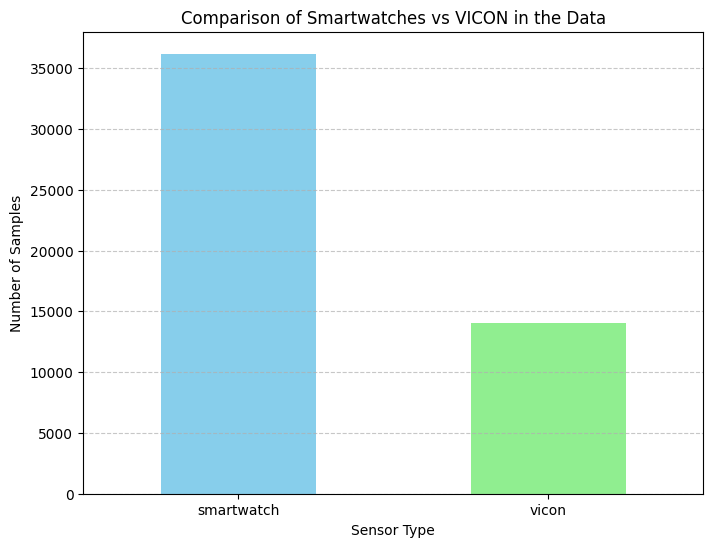

In [ ]:
# Path to the train CSV file
train_file_path = '/content/data/train.csv'

# Load the train data
df = pd.read_csv(train_file_path)

# Count occurrences of each sensor type (smartwatch vs vicon)
sensor_counts = df['sensor'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 6))
sensor_counts.plot(kind='bar', color=['skyblue', 'lightgreen'])  # Adjust colors as needed
plt.title('Comparison of Smartwatches vs VICON in the Data')
plt.xlabel('Sensor Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

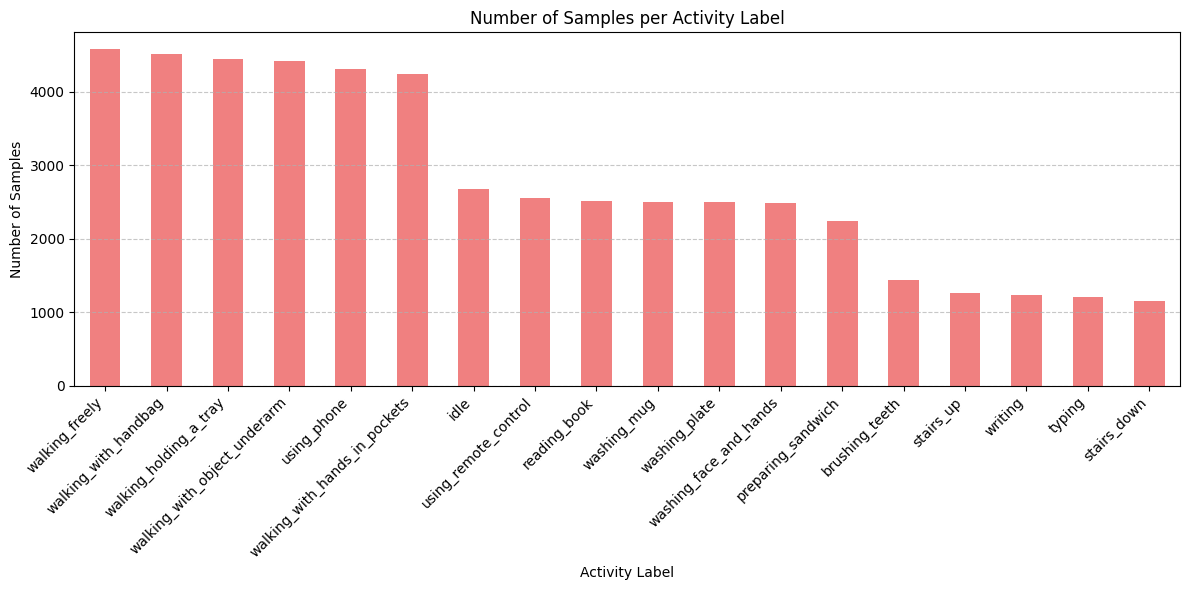

In [ ]:
# Load the train data
df = pd.read_csv(train_file_path)

# Count the number of samples per activity label
activity_counts = df['activity'].value_counts()

# Plot the bar chart
plt.figure(figsize=(12, 6))
activity_counts.plot(kind='bar', color='lightcoral')  # Adjust the color as needed
plt.title('Number of Samples per Activity Label')
plt.xlabel('Activity Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

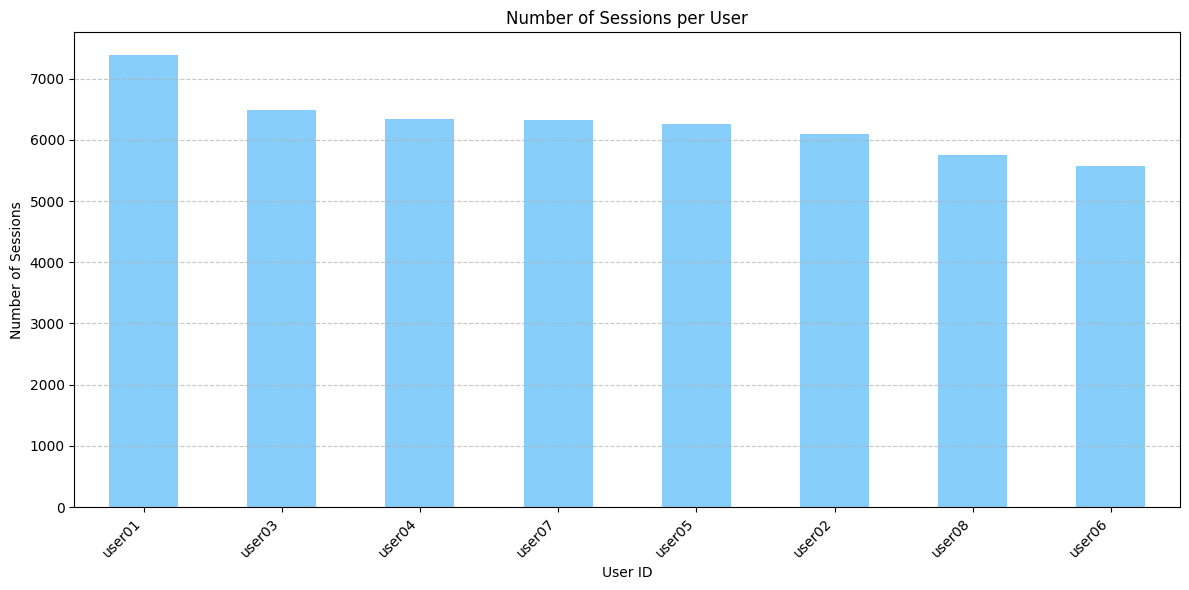

In [ ]:
train_file_path = '/content/data/train.csv'

# Load the train data
df = pd.read_csv(train_file_path)

# Count the number of unique 'id' values for each 'userid'
sessions_per_user = df.groupby('userid')['id'].nunique().sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 6))
sessions_per_user.plot(kind='bar', color='lightskyblue')
plt.title('Number of Sessions per User')
plt.xlabel('User ID')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

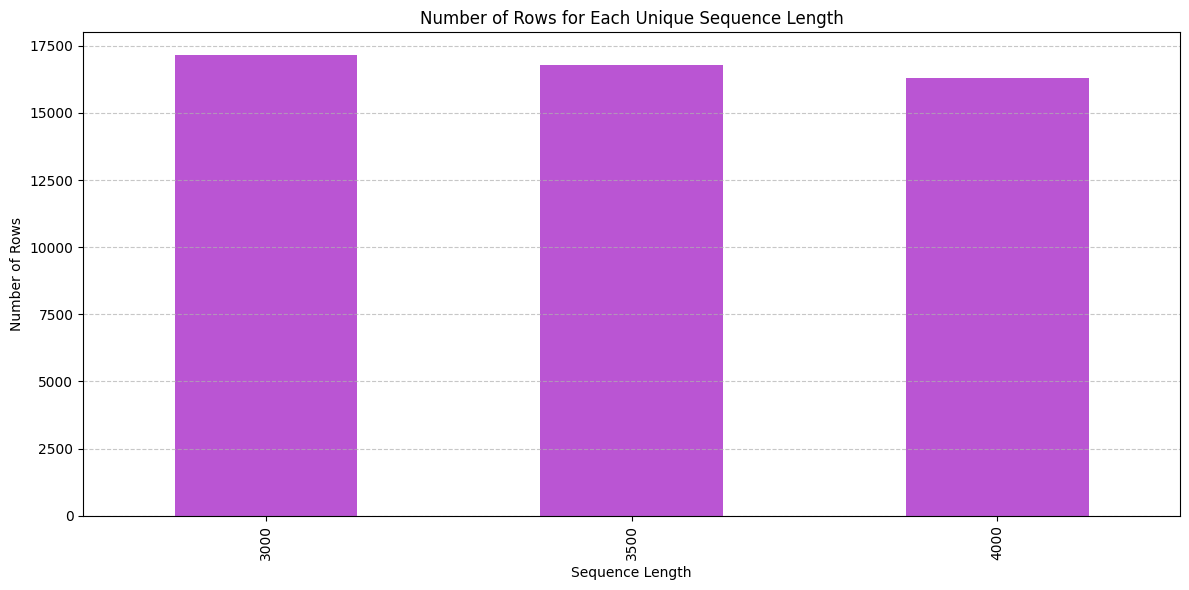

In [ ]:
# Count how many rows exist for each unique sequence_length
sequence_length_counts = df['sequence_length'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(12, 6))
sequence_length_counts.plot(kind='bar', color='mediumorchid')
plt.title('Number of Rows for Each Unique Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Number of Rows')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

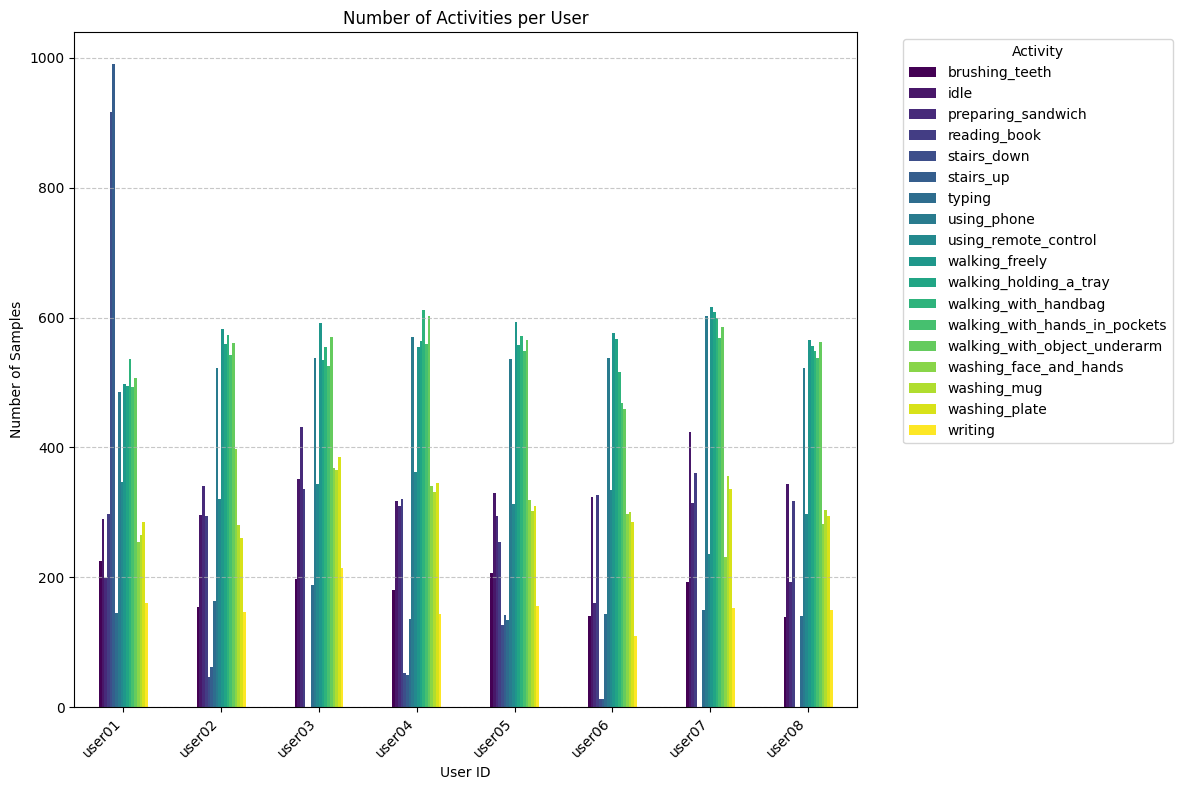

In [ ]:
# Count the number of activities for each user
activity_counts = df.groupby(['userid', 'activity']).size().unstack(fill_value=0)

# Plot the grouped bar chart
activity_counts.plot(kind='bar', stacked=False, figsize=(12, 8), colormap='viridis')

# Customize the plot
plt.title('Number of Activities per User')
plt.xlabel('User ID')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Activity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
unlabeled_dir = '/content/data/unlabeled/unlabeled/'

# Load the train data
train_df = pd.read_csv(train_file_path)

# Calculate the number of rows (samples) in the train data
num_train_samples = len(train_df)

num_sessions = len([f for f in os.listdir(unlabeled_dir) if f.endswith('.csv')])

# Calculate the number of test items
num_test_items = num_sessions - num_train_samples

# Print the results
print(f"Number of samples in the train: {num_train_samples}")
print(f"Total number of sessions (test): {num_sessions}")
print(f"Number of items in the test: {num_test_items}")


Number of samples in the train: 50248
Total number of sessions (test): 124992
Number of items in the test: 74744


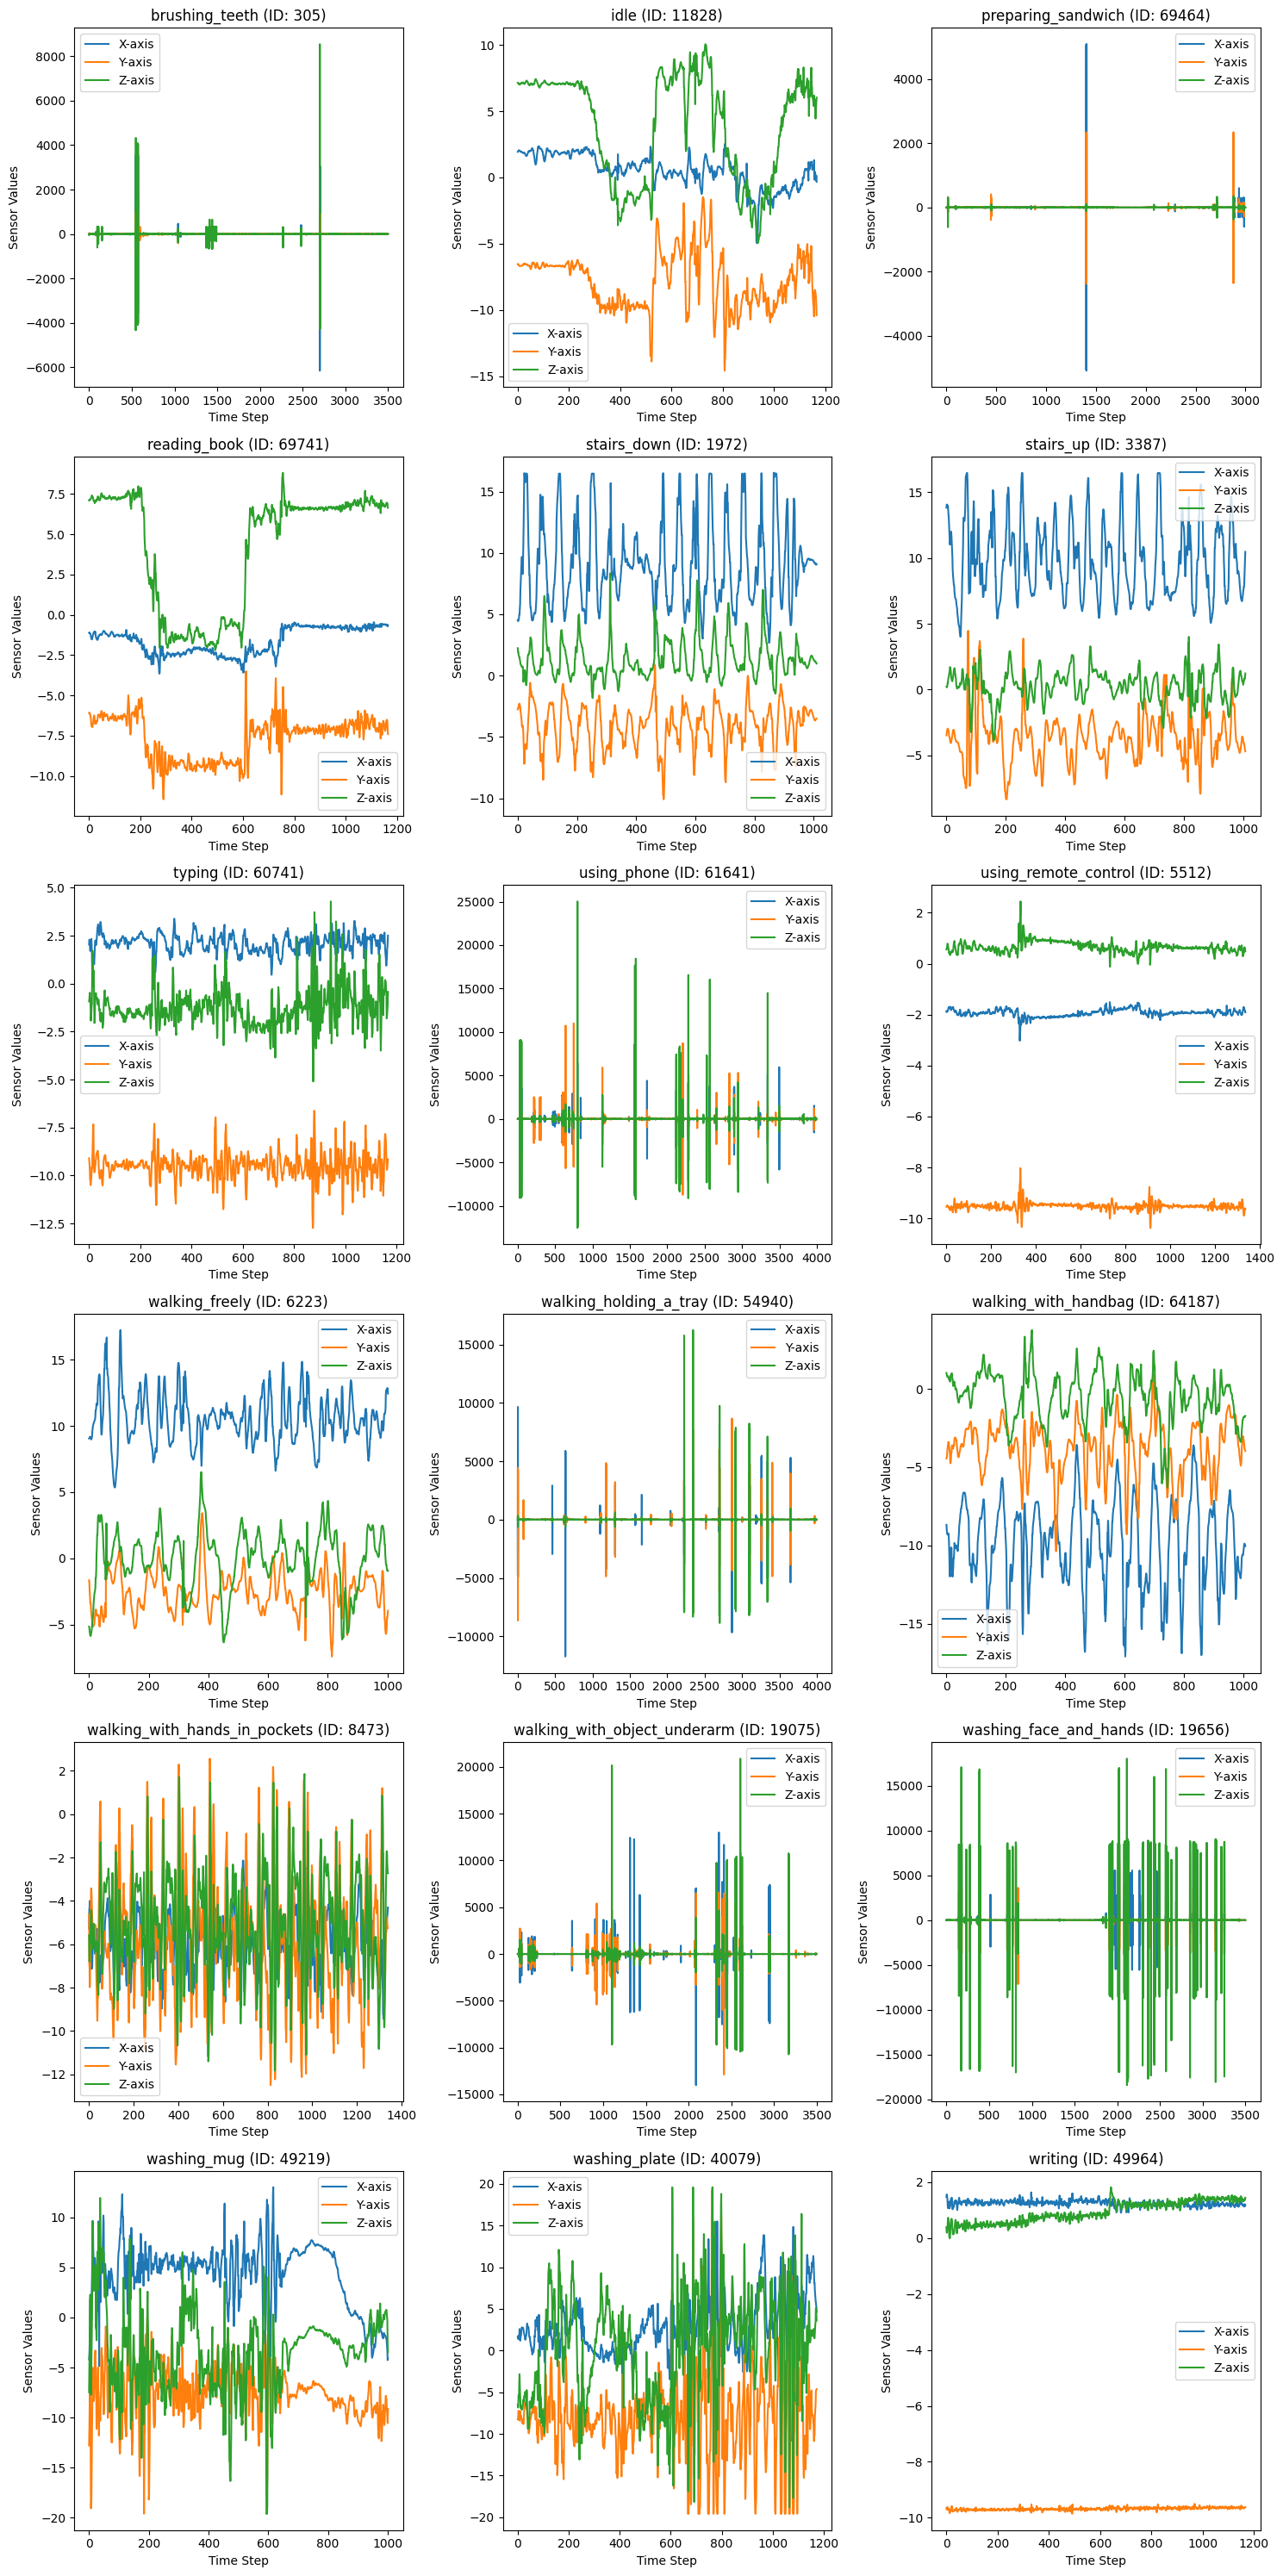

In [ ]:
# Step 1: Extract one ID per activity
train_df = pd.read_csv(train_file_path)
unique_activities = train_df.groupby("activity").first().reset_index()
activity_id_mapping = unique_activities[['activity', 'id']]

# Step 2: Initialize plot grid
num_plots = len(activity_id_mapping)
cols = 3  # Number of columns in the grid
rows = math.ceil(num_plots / cols)  # Calculate rows needed
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 5 * rows))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Step 3: Loop through each activity and ID
for i, row in enumerate(activity_id_mapping.iterrows()):
    activity = row[1]['activity']
    file_id = row[1]['id']
    file_path = f"/content/data/unlabeled/unlabeled/{file_id}.csv"  # Assumes CSV files are named as IDs

    try:
        # Load the corresponding CSV
        data = pd.read_csv(file_path)

        # Plot x, y, z over time
        axes[i].plot(data.iloc[:, 0], label='X-axis')
        axes[i].plot(data.iloc[:, 1], label='Y-axis')
        axes[i].plot(data.iloc[:, 2], label='Z-axis')
        axes[i].set_title(f'{activity} (ID: {file_id})')
        axes[i].set_xlabel('Time Step')
        axes[i].set_ylabel('Sensor Values')
        axes[i].legend()

    except FileNotFoundError:
        axes[i].set_title(f'{activity} (ID: {file_id} - CSV Not Found)')

# Turn off unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# naïve baseline

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Path to the train CSV file
train_file_path = '/content/data/train.csv'

# Load the train data
train_df = pd.read_csv(train_file_path)

# Step 1: Split by userID
# Get the unique userIDs
user_ids = train_df['userid'].unique()

# Split the users: 5 for training, 2 for validation
train_users, val_users = train_test_split(user_ids, test_size=2/7, random_state=42)

# Separate the data based on the split
train_data = train_df[train_df['userid'].isin(train_users)]
val_data = train_df[train_df['userid'].isin(val_users)]

# Step 2: Calculate class probabilities from the training set
class_distribution = train_data['activity'].value_counts(normalize=True)
print("Class Distribution (Probabilities):")
print(class_distribution)

# Step 3: Extract ground truth labels for validation
y_val = val_data['activity'].values

# Step 4: Random guessing based on class probabilities
np.random.seed(42)  # For reproducibility
random_predictions = np.random.choice(
    class_distribution.index,  # List of activities
    size=len(y_val),           # Number of predictions
    p=class_distribution.values  # Probability distribution
)

# Step 5: Evaluate the performance
accuracy = accuracy_score(y_val, random_predictions)

print(f"Validation Accuracy (Naïve Baseline - Class Distribution): {accuracy:.4f}")


Class Distribution (Probabilities):
activity
walking_freely                   0.095512
walking_with_handbag             0.093781
walking_holding_a_tray           0.093323
walking_with_object_underarm     0.090579
using_phone                      0.090416
walking_with_hands_in_pockets    0.087738
idle                             0.055204
washing_face_and_hands           0.051806
washing_mug                      0.051284
using_remote_control             0.051153
reading_book                     0.050892
washing_plate                    0.050173
preparing_sandwich               0.046351
brushing_teeth                   0.028549
typing                           0.023682
writing                          0.023094
stairs_up                        0.008689
stairs_down                      0.007774
Name: proportion, dtype: float64
Validation Accuracy (Naïve Baseline - Class Distribution): 0.0655


# classical machine learning model

extracting features

In [ ]:
# Paths to the data
train_file_path = '/content/data/train.csv'
unlabeled_dir = '/content/data/unlabeled/unlabeled/'

# Load the train CSV
train_df = pd.read_csv(train_file_path)

# Function to calculate features from a single session
def extract_features(file_path):
    df = pd.read_csv(file_path)
    features = {}
    if 'x' in df.columns and 'y' in df.columns and 'z' in df.columns:
        for axis in ['x', 'y', 'z']:
            data = df[axis]
            features[f'{axis}_mean'] = int(np.round(data.mean()))
            features[f'{axis}_std'] = int(np.round(data.std()))
            features[f'{axis}_min'] = int(data.min())
            features[f'{axis}_max'] = int(data.max())
            features[f'{axis}_range'] = int(data.max() - data.min())
            features[f'{axis}_rms'] = int(np.round(np.sqrt(np.mean(data**2))))
        features['sma'] = int(np.round(np.abs(df[['x', 'y', 'z']]).values.sum()))
        features['sequence_length'] = len(df)  # Number of rows
    return features

# Create a DataFrame to store all extracted features
feature_list = []

# Loop through all sessions in train_df
for session_id, activity in zip(train_df['id'], train_df['activity']):
    file_path = os.path.join(unlabeled_dir, f"{session_id}.csv")
    if os.path.exists(file_path):
        features = extract_features(file_path)
        features['id'] = session_id
        features['activity'] = activity
        feature_list.append(features)

# Create a DataFrame from the feature list
features_df = pd.DataFrame(feature_list)

# Save the extracted features as a CSV
output_path = '/content/extracted_features.csv'
features_df.to_csv(output_path, index=False)

print(f"Feature extraction complete! Features saved to {output_path}")
print(features_df.head())

Feature extraction complete! Features saved to /content/extracted_features.csv
   x_mean  x_std  x_min  x_max  x_range  x_rms  y_mean  y_std  y_min  y_max  \
0      10      3      4     16       12     10      -4      2     -8      4   
1      -6      1    -11     -1        9      6      -6      3    -12      2   
2       8      2      4     12        8      8      -6      3    -14      1   
3      11      2      5     17       11     11      -2      2     -7      3   
4       0    440  -7581   6440    14022    440       0    533  -8724  10991   

   ...  z_mean  z_std  z_min  z_max  z_range  z_rms      sma  sequence_length  \
0  ...       0      1     -3      4        7      1    14664             1007   
1  ...      -5      2    -11      1       13      6    22549             1340   
2  ...       0      2     -7      6       14      2    16146             1002   
3  ...       0      2     -6      6       12      2    14851             1003   
4  ...       0   1146 -12535  25023    37

In [ ]:
# Step 1: Load the data
features_csv_path = '/content/extracted_features.csv'
features_df = pd.read_csv(features_csv_path)

# Step 2: Split data by userID
user_ids = features_df['userid'].unique()  # Extract unique user IDs
train_users, val_users = train_test_split(user_ids, test_size=2/7, random_state=42)  # Split users (5 for train, 2 for val)

# Separate the data based on the user split
train_data = features_df[features_df['userid'].isin(train_users)]
val_data = features_df[features_df['userid'].isin(val_users)]

# Prepare the data for training and validation
X_train = train_data.drop(columns=['id', 'userid', 'activity'])  # Drop non-feature columns
y_train = train_data['activity']
X_val = val_data.drop(columns=['id', 'userid', 'activity'])
y_val = val_data['activity']

# Step 3: Train Random Forest with reduced complexity
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=45
)
rf_model.fit(X_train, y_train)

# Step 4: Cross-validation on the training set
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Step 5: Evaluate on the validation set
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Detailed performance report
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))


Cross-Validation Accuracy: 0.7570 ± 0.0042
Train Accuracy: 0.7893
Validation Accuracy: 0.4392

Classification Report (Validation Set):
                               precision    recall  f1-score   support

               brushing_teeth       0.34      0.29      0.31       561
                         idle       0.33      0.34      0.34       985
           preparing_sandwich       0.29      0.44      0.35       823
                 reading_book       0.62      0.47      0.53       950
                  stairs_down       0.54      0.72      0.62       917
                    stairs_up       0.19      0.06      0.09       990
                       typing       0.44      0.56      0.49       474
                  using_phone       0.51      0.70      0.59      1545
         using_remote_control       0.44      0.44      0.44       986
               walking_freely       0.34      0.50      0.41      1654
       walking_holding_a_tray       0.65      0.65      0.65      1584
         wal

# plot makes

In [ ]:
def plot_training_results(csv_path):
    """
    Plots the training and validation accuracy and loss from the given CSV file.
    Ensures one data point per epoch.

    Args:
        csv_path (str): Path to the CSV file containing training logs.
    """
    # Read the CSV
    df = pd.read_csv(csv_path)

    # Group by epoch to ensure one point per epoch
    grouped = df.groupby('epoch').mean()

    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(grouped.index, grouped['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(grouped.index, grouped['val_acc'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(grouped.index, grouped['train_loss'], label='Train Loss', marker='o')
    plt.plot(grouped.index, grouped['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()



def compare_model_accuracies_with_plot(csv_path1, csv_path2):
    """
    Plots the weighted average validation accuracy per epoch for two models.

    Args:
        csv_path1 (str): Path to the first model's CSV file (Smartwatch).
        csv_path2 (str): Path to the second model's CSV file (VICON).
    """
    # Constants for dataset sizes
    smartwatch_size = 8279
    vicon_size = 3638

    # Read the CSVs
    df1 = pd.read_csv(csv_path1)  # Smartwatch
    df2 = pd.read_csv(csv_path2)  # VICON

    # Group by epoch to ensure one point per epoch
    grouped_df1 = df1.groupby('epoch').mean()
    grouped_df2 = df2.groupby('epoch').mean()

    # Calculate weighted accuracy
    total_size = smartwatch_size + vicon_size
    weights1 = smartwatch_size / total_size
    weights2 = vicon_size / total_size

    weighted_avg_acc = (grouped_df1['val_acc'] * weights1) + (grouped_df2['val_acc'] * weights2)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(grouped_df1.index, grouped_df1['val_acc'], label='Smartwatch Validation Accuracy', marker='o')
    plt.plot(grouped_df2.index, grouped_df2['val_acc'], label='VICON Validation Accuracy', marker='o')
    plt.plot(grouped_df1.index, weighted_avg_acc, label='Weighted Average Validation Accuracy', linestyle='--', color='red')
    plt.title('Weighted Average Validation Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()




# data loaders

In [ ]:
# Define dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, train_csv, data_dir,activity_map=None,inverse_activity_map=None):
        """
        Args:
            train_csv (str): Path to the train.csv file.
            data_dir (str): Directory containing session CSV files.
        """
        self.train_df = pd.read_csv(train_csv)
        self.data_dir = data_dir

        # Automatically map activities to integer labels
        if activity_map is None:
            self.activity_map = {activity: idx for idx, activity in enumerate(self.train_df['activity'].unique())}
            self.inverse_activity_map = {idx: activity for activity, idx in self.activity_map.items()}
        else:
            self.activity_map = activity_map
            self.inverse_activity_map = inverse_activity_map

    def __len__(self):
        """Return the total number of sessions."""
        return len(self.train_df)

    def __getitem__(self, idx):
        """
        Load the session data and corresponding activity label.
        Args:
            idx (int): Index of the sample.
        Returns:
            tuple: (time_series_data, label)
        """
        row = self.train_df.iloc[idx]
        session_id = row['id']
        activity = row['activity']

        # Load the session CSV
        session_path = os.path.join(self.data_dir, f"{session_id}.csv")
        session_data = pd.read_csv(session_path)

        # Extract x, y, z columns and convert to PyTorch tensor
        time_series_data = torch.tensor(session_data[['x', 'y', 'z']].values.T, dtype=torch.float32)  # Shape: (3, sequence_length)

        # Convert activity to label
        label = self.activity_map[activity]

        return time_series_data, label



# 1D-CNN basic

In [ ]:
class CNN1D(pl.LightningModule):
    def __init__(self, min_length, input_dim=3, num_classes=18, log_csv_name="training_log.csv"):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Dynamically compute the flattened size after convolutions and pooling
        pooled_length = min_length // 2 // 2  # Adjust based on pooling layers
        self.fc_layers = nn.Sequential(
            nn.Linear(pooled_length * 64, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)  # No activation here
        )
        # Path to save the CSV
        self.log_csv_name = log_csv_name
        if log_csv_name:
            with open(log_csv_name, 'w') as f:
                f.write('epoch,train_loss,train_acc,val_loss,val_acc\n')

        # Metrics for aggregation
        self.train_metrics = []
        self.val_metrics = []


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = self.fc_layers(x)
        return x


    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.train_metrics.append({'loss': loss.item(), 'acc': acc.item()})
        return loss


    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('val_loss_epoch', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc_epoch', acc, on_epoch=True, prog_bar=True, logger=True)
        self.val_metrics.append({'loss': loss.item(), 'acc': acc.item()})
        return loss


    def on_validation_epoch_end(self):
        # Aggregate metrics for the epoch
        if len(self.train_metrics) != 0:
            train_loss_mean = sum([m['loss'] for m in self.train_metrics]) / len(self.train_metrics)
            train_acc_mean = sum([m['acc'] for m in self.train_metrics]) / len(self.train_metrics)
            val_loss_mean = sum([m['loss'] for m in self.val_metrics]) / len(self.val_metrics)
            val_acc_mean = sum([m['acc'] for m in self.val_metrics]) / len(self.val_metrics)

            # Log to CSV if enabled
            if self.log_csv_name:
                with open(self.log_csv_name, 'a') as f:
                    f.write(f"{self.current_epoch},{train_loss_mean},{train_acc_mean},{val_loss_mean},{val_acc_mean}\n")

            # Clear metrics for the next epoch
            self.train_metrics.clear()
            self.val_metrics.clear()


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optimizer


In [ ]:
def create_dataloaders(train_csv_path, data_dir, batch_size, min_length ,test_size=2/8, random_state=42):
    """
    Create train and validation DataLoaders with sequences trimmed to the minimum sequence length in the dataset.

    Args:
        train_csv_path (str): Path to the train.csv file.
        data_dir (str): Directory containing the dataset files.
        batch_size (int): Batch size for DataLoaders.
        test_size (float): Proportion of users for validation split.
        random_state (int): Random seed for reproducibility.

    Returns:
        train_loader (DataLoader): DataLoader for training.
        val_loader (DataLoader): DataLoader for validation.
    """
    # Load train.csv
    train_csv = pd.read_csv(train_csv_path)

    # Split by user ID
    user_ids = train_csv['userid'].unique()
    train_users, val_users = train_test_split(user_ids, test_size=test_size, random_state=random_state)
    print(f"Number of users in training set: {len(train_users)}")
    print(f"Number of users in validation set: {len(val_users)}")

    # Create train and validation DataFrames
    train_df = train_csv[train_csv['userid'].isin(train_users)]
    val_df = train_csv[train_csv['userid'].isin(val_users)]

    # Save temporary CSVs for train and validation
    train_split_path = os.path.join(data_dir, 'train_split.csv')
    val_split_path = os.path.join(data_dir, 'val_split.csv')
    train_df.to_csv(train_split_path, index=False)
    val_df.to_csv(val_split_path, index=False)

    # Create datasets
    train_dataset = TimeSeriesDataset(train_split_path, data_dir)
    val_dataset = TimeSeriesDataset(val_split_path, data_dir,activity_map=train_dataset.activity_map,inverse_activity_map=train_dataset.inverse_activity_map)

    print("Train activity_map:", train_dataset.activity_map)
    print("Val activity_map:", val_dataset.activity_map)


    print(f"Minimum sequence length in the dataset: {min_length}")

    # Define a custom collate function using the minimum sequence length
    def custom_collate_fn(batch):
        data, labels = zip(*batch)

        # Trim or pad each sequence to `min_length`
        trimmed_data = torch.stack([
            seq.clone().detach()[:, :min_length]  # Trim to the minimum length
            for seq in data
        ])

        labels = torch.tensor(labels, dtype=torch.long)
        return trimmed_data, labels

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=custom_collate_fn,
        num_workers=8
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=custom_collate_fn,
        num_workers=8
    )

    return train_loader, val_loader


Number of users in training set: 7
Number of users in validation set: 1
Minimum sequence length in the dataset: 999
Number of users in training set: 7
Number of users in validation set: 1
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Minimum sequence length in the dataset: 3000
Data loaders for VICON and Smartwatch datasets are ready.
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(

In [ ]:
BATCH_SIZE = 128
MAX_EPOCHS = 10

# Define paths and constants
vicon_csv_path = '/content/data_experiment/vicon/train.csv'
smartwatch_csv_path = '/content/data_experiment/smartwatch/train.csv'
vicon_data_dir = '/content/data_experiment/vicon/'
smartwatch_data_dir = '/content/data_experiment/smartwatch/'
vicon_min_length = 999
smartwatch_min_length = 3000

# Create VICON DataLoaders min is 999
vicon_train_loader, vicon_val_loader = create_dataloaders(vicon_csv_path,vicon_data_dir,BATCH_SIZE,vicon_min_length)

# Create Smartwatch DataLoaders min is 3000
smartwatch_train_loader, smartwatch_val_loader = create_dataloaders(smartwatch_csv_path, smartwatch_data_dir, BATCH_SIZE,smartwatch_min_length)


print("Data loaders for VICON and Smartwatch datasets are ready.")

In [ ]:
smartwatch_model = CNN1D(min_length=smartwatch_min_length,log_csv_name="CNN1D_smartwatch_log_1.csv")

# Define the Trainer
smartwatch_trainer = Trainer(max_epochs=MAX_EPOCHS, accelerator='auto', devices=1)

# Train the models
smartwatch_trainer.fit(smartwatch_model, train_dataloaders=smartwatch_train_loader, val_dataloaders=smartwatch_val_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type       | Params
-------------------------------------------
0 | conv_layers | Sequential | 6.5 K 
1 | fc_layers   | Sequential | 6.2 M 
-------------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M     Total params
24.904    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
vicon_model = CNN1D(min_length=vicon_min_length,log_csv_name="CNN1D_vicon_log_1.csv")

trainer_vicon = Trainer(max_epochs=MAX_EPOCHS, accelerator='auto', devices=1)
trainer_vicon.fit(vicon_model, train_dataloaders=vicon_train_loader, val_dataloaders=vicon_val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type       | Params
-------------------------------------------
0 | conv_layers | Sequential | 6.5 K 
1 | fc_layers   | Sequential | 2.1 M 
-------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.487     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


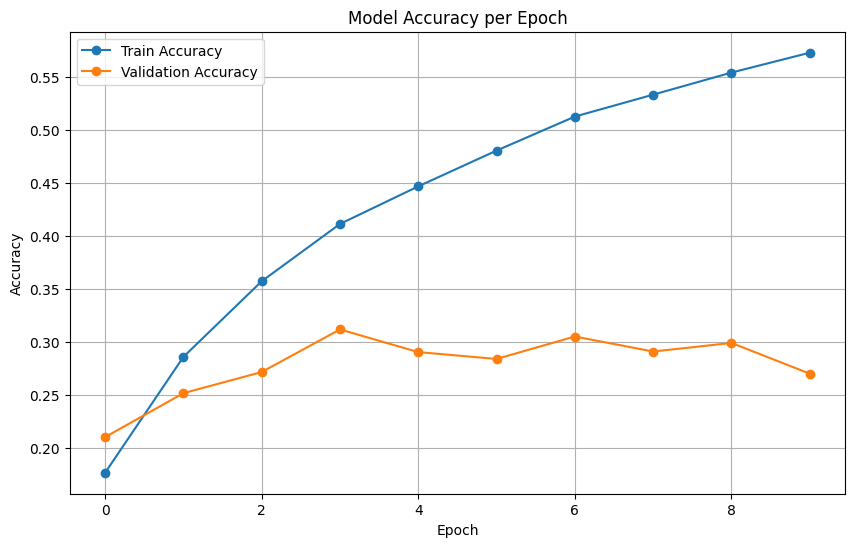

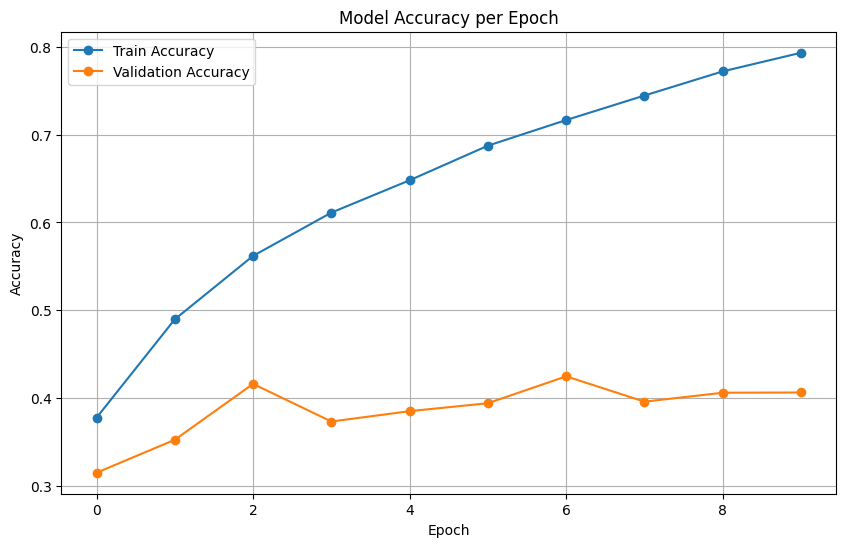

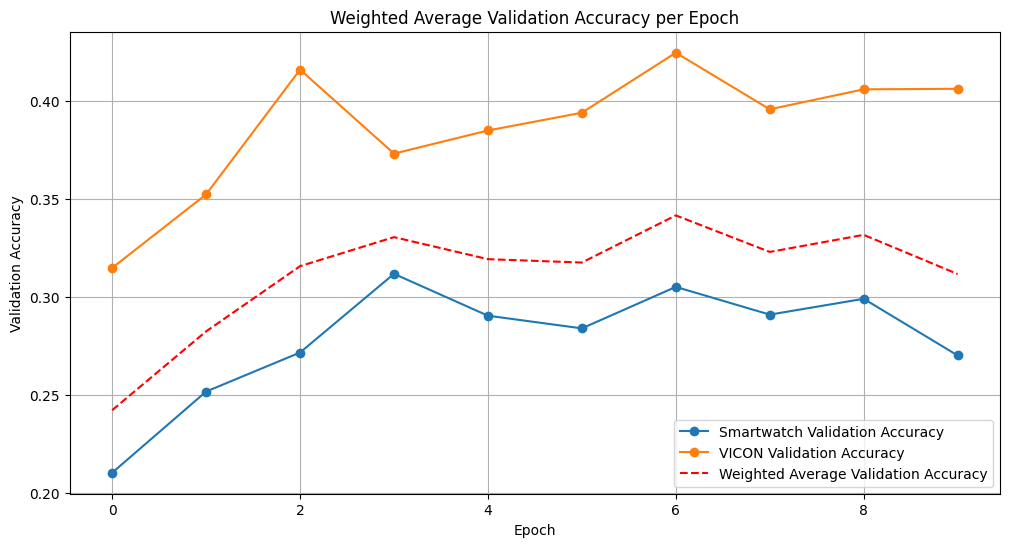

In [ ]:
plot_training_results('/content/CNN1D_smartwatch_log_1.csv')
plot_training_results('/content/CNN1D_vicon_log_1.csv')
compare_model_accuracies_with_plot('/content/CNN1D_smartwatch_log_1.csv', '/content/CNN1D_vicon_log_1.csv')


# LSTM basic

In [ ]:
class LSTMModel(pl.LightningModule):
    def __init__(self, min_length, input_dim=3, hidden_dim=128, num_classes=18, num_layers=2, bidirectional=False, log_csv_name="training_log.csv"):
        super().__init__()
        self.min_length = min_length
        self.bidirectional = bidirectional

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.2  # Internal dropout for LSTM
        )

        # Fully connected layers
        lstm_output_dim = hidden_dim * (2 if bidirectional else 1)
        self.fc_layers = nn.Sequential(
            nn.Linear(lstm_output_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)  # No activation here
        )

        # Path to save the CSV
        self.log_csv_name = log_csv_name
        if log_csv_name:
            with open(log_csv_name, 'w') as f:
                f.write('epoch,train_loss,train_acc,val_loss,val_acc\n')

        # Metrics for aggregation
        self.train_metrics = []
        self.val_metrics = []

    def forward(self, x):
        # LSTM expects input as (batch_size, sequence_length, input_dim)
        x = x.permute(0, 2, 1)  # Reshape from (batch_size, channels, sequence_length) to (batch_size, sequence_length, input_dim)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Take the last time step
        x = self.fc_layers(lstm_out)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.train_metrics.append({'loss': loss.item(), 'acc': acc.item()})
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('val_loss_epoch', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc_epoch', acc, on_epoch=True, prog_bar=True, logger=True)
        self.val_metrics.append({'loss': loss.item(), 'acc': acc.item()})
        return loss

    def on_validation_epoch_end(self):
        # Aggregate metrics for the epoch
        if len(self.train_metrics) != 0:
            train_loss_mean = sum([m['loss'] for m in self.train_metrics]) / len(self.train_metrics)
            train_acc_mean = sum([m['acc'] for m in self.train_metrics]) / len(self.train_metrics)
            val_loss_mean = sum([m['loss'] for m in self.val_metrics]) / len(self.val_metrics)
            val_acc_mean = sum([m['acc'] for m in self.val_metrics]) / len(self.val_metrics)

            # Log to CSV if enabled
            if self.log_csv_name:
                with open(self.log_csv_name, 'a') as f:
                    f.write(f"{self.current_epoch},{train_loss_mean},{train_acc_mean},{val_loss_mean},{val_acc_mean}\n")

            # Clear metrics for the next epoch
            self.train_metrics.clear()
            self.val_metrics.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optimizer


In [ ]:
BATCH_SIZE = 32
MAX_EPOCHS = 10

# Define paths and constants
vicon_csv_path = '/content/data_experiment/vicon/train.csv'
smartwatch_csv_path = '/content/data_experiment/smartwatch/train.csv'
vicon_data_dir = '/content/data_experiment/vicon/'
smartwatch_data_dir = '/content/data_experiment/smartwatch/'
vicon_min_length = 999
smartwatch_min_length = 3000

# Create VICON DataLoaders min is 999
vicon_train_loader, vicon_val_loader = create_dataloaders(vicon_csv_path,vicon_data_dir,BATCH_SIZE,vicon_min_length)

# Create Smartwatch DataLoaders min is 3000
smartwatch_train_loader, smartwatch_val_loader = create_dataloaders(smartwatch_csv_path, smartwatch_data_dir, BATCH_SIZE,smartwatch_min_length)


print("Data loaders for VICON and Smartwatch datasets are ready.")

In [ ]:
smartwatch_model = LSTMModel(min_length=smartwatch_min_length,log_csv_name="LSTM_smartwatch_log_1.csv")

# Define the Trainer
smartwatch_trainer = Trainer(max_epochs=MAX_EPOCHS, accelerator='auto', devices=1)

# Train the models
smartwatch_trainer.fit(smartwatch_model, train_dataloaders=smartwatch_train_loader, val_dataloaders=smartwatch_val_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params
-----------------------------------------
0 | lstm      | LSTM       | 200 K 
1 | fc_layers | Sequential | 91.8 K
-----------------------------------------
291 K     Trainable params
0         Non-trainable params
291 K     Total params
1.168     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
vicon_model = LSTMModel(min_length=vicon_min_length,log_csv_name="LSTM_vicon_log_1.csv")

trainer_vicon = Trainer(max_epochs=MAX_EPOCHS, accelerator='auto', devices=1)
trainer_vicon.fit(vicon_model, train_dataloaders=vicon_train_loader, val_dataloaders=vicon_val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params
-----------------------------------------
0 | lstm      | LSTM       | 200 K 
1 | fc_layers | Sequential | 91.8 K
-----------------------------------------
291 K     Trainable params
0         Non-trainable params
291 K     Total params
1.168     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


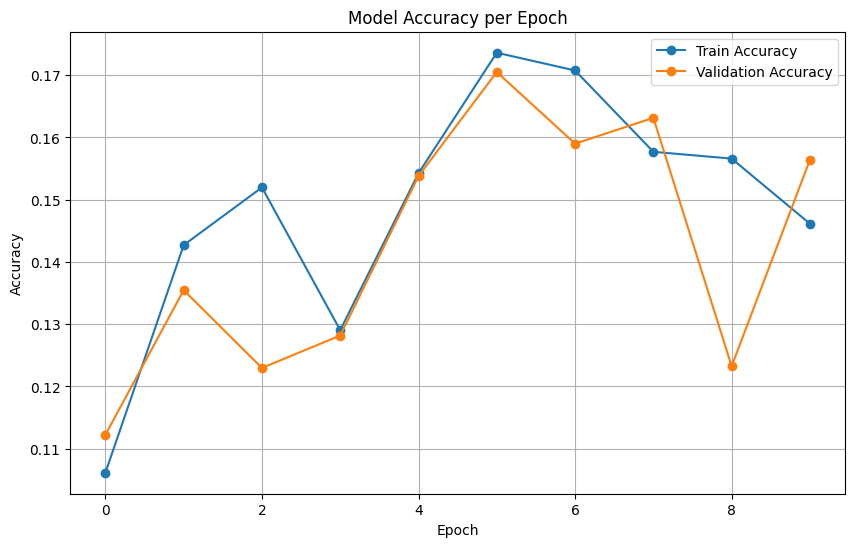

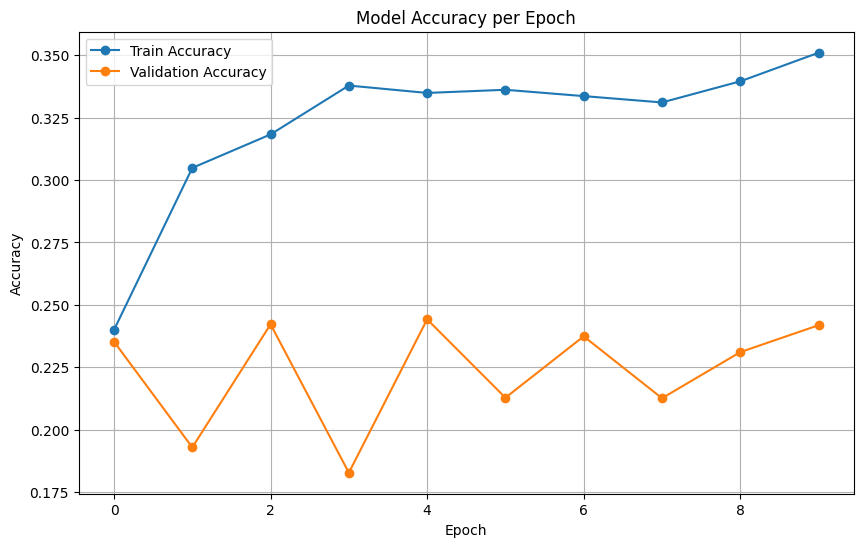

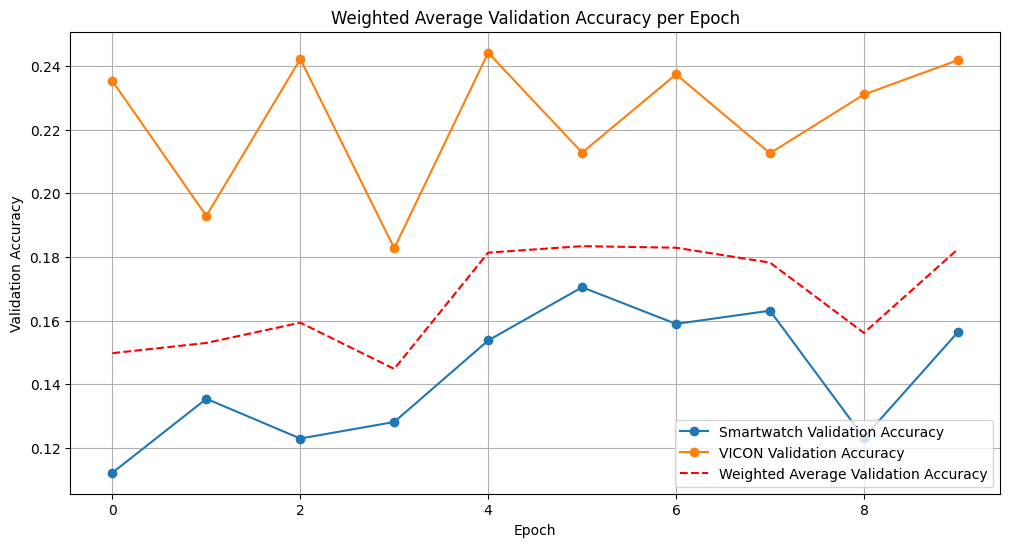

In [ ]:
plot_training_results('/content/LSTM_smartwatch_log_1.csv')
plot_training_results('/content/LSTM_vicon_log_1.csv')
compare_model_accuracies_with_plot('/content/LSTM_smartwatch_log_1.csv', '/content/LSTM_vicon_log_1.csv')


# Autoencoder preprocess

unzip new data zip

In [ ]:
import zipfile
import os

# Path to the zip file
zip_file_path = "/content/new_data.zip"

# Destination folder
destination_folder = "/content/"

# Check if the zip file exists
if os.path.exists(zip_file_path):
    try:
        # Unzipping the file
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(destination_folder)
            print(f"Unzipped '{zip_file_path}' to '{destination_folder}' successfully.")
    except Exception as e:
        print(f"Error unzipping file: {e}")
else:
    print(f"Zip file '{zip_file_path}' does not exist.")


Unzipped '/content/new_data.zip' to '/content/' successfully.


In [ ]:
def create_sliding_window_index_csv(main_dir, window_size, step_size, output_csv):
    index_data = []
    # Traverse the directory and process each CSV file
    for root, _, files in os.walk(main_dir):
        for file_name in files:
            if file_name.endswith('.csv'):
                file_path = os.path.join(root, file_name)

                # Load the CSV file to determine the number of rows
                df = pd.read_csv(file_path)
                num_rows = len(df)

                # Create sliding windows for the current file
                for start in range(0, num_rows - window_size + 1, step_size):
                    end = start + window_size
                    index_data.append({
                        "file_path": file_path,
                        "start_row": start,
                        "end_row": end
                    })

    # Convert the index data to a DataFrame and save to CSV
    index_df = pd.DataFrame(index_data)
    index_df.to_csv(output_csv, index=False)
    print(f"Index CSV created: {output_csv}")



main_dir = "/content/new_data/vicon"  # Replace with your directory path
window_size = 50  # Number of rows per window
step_size = 50  # Step size for the sliding window
output_csv = "/content/vicon_index.csv"  # Path to save the index CSV

# Create the sliding window index CSV
create_sliding_window_index_csv(main_dir, window_size, step_size, output_csv)


Index CSV created: /content/vicon_index.csv


In [ ]:
main_dir = "/content/new_data/smartwatch"  # Replace with your directory path

output_csv = "/content/smartwatch_index.csv"  # Path to save the index CSV

create_sliding_window_index_csv(main_dir, window_size, step_size, output_csv)


Index CSV created: /content/smartwatch_index.csv


In [ ]:
class SlidingWindowDataset(Dataset):
    def __init__(self, index_csv):
        self.index_df = pd.read_csv(index_csv)

    def __len__(self):
        return len(self.index_df)

    def __getitem__(self, idx):
        # Retrieve the metadata for the sliding window
        row = self.index_df.iloc[idx]
        file_path = row["file_path"]
        start_row = int(row["start_row"])
        end_row = int(row["end_row"])

        # Load the corresponding CSV file and extract the sliding window
        df = pd.read_csv(file_path)
        sliding_window = df.iloc[start_row:end_row][["x", "y", "z"]].values

        # Convert to PyTorch tensor
        sliding_window_tensor = torch.tensor(sliding_window, dtype=torch.float32)

        # Return only the sliding window (no label needed for autoencoder)
        return sliding_window_tensor


In [ ]:
def create_dataloader(index_csv, batch_size, shuffle=True, num_workers=8):
    dataset = SlidingWindowDataset(index_csv)

    def custom_collate_fn(batch):
        return torch.stack(batch, dim=0)  # Stack tensors along a new dimension

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=custom_collate_fn,
        num_workers=num_workers,
        pin_memory=True
    )
    return dataloader


# Paths to the index CSVs
vicon_index_csv = "/content/vicon_index.csv"
smartwatch_index_csv = "/content/smartwatch_index.csv"

BATCH_SIZE = 128
# Create DataLoaders for VICON and Smartwatch datasets

vicon_dataloader = create_dataloader(vicon_index_csv, BATCH_SIZE)
smartwatch_dataloader = create_dataloader(smartwatch_index_csv, BATCH_SIZE)

# Example: Iterate through one DataLoader
for batch in vicon_dataloader:
    print(f"Batch shape: {batch.shape}")  # Expecting (batch_size, window_size, 3)
    break



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch shape: torch.Size([128, 50, 3])


# Autoencoder

In [ ]:
class SlidingWindowAutoencoder(pl.LightningModule):
    def __init__(self, window_size=50, input_dim=3, latent_dim=16, learning_rate=0.001):
        super().__init__()
        self.window_size = window_size
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate


        # Calculate flattened size after Conv1d layers
        self.flattened_size = 13 * 32  # which is 416

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.flattened_size, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, self.flattened_size),
            nn.ReLU(),
            nn.Unflatten(1, (32, 13)),
            nn.ConvTranspose1d(in_channels=32, out_channels=16,kernel_size=3, stride=2, padding=1,output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=3,kernel_size=3, stride=2, padding=1,output_padding=1)        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Shape: [batch_size, channels, sequence_length]
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.permute(0, 2, 1)  # Back to [batch_size, sequence_length, channels]
        return decoded

    def training_step(self, batch, batch_idx):
        x = batch
        reconstructed = self(x)
        loss = nn.MSELoss()(reconstructed, x)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch
        reconstructed = self(x)
        loss = nn.MSELoss()(reconstructed, x)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss



    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [ ]:
# 1. Instantiate your autoencoder without needing the 'log_csv_name'
autoencoder_vicon = SlidingWindowAutoencoder(
    window_size=50,
    input_dim=3,
    latent_dim=16,
    learning_rate=0.001
)

# 2. Create a CSVLogger
csv_logger_vicon = CSVLogger(
    save_dir='/content/',              # folder where metrics are saved
    name='autoencoder_vicon_training_log'       # subfolder/experiment name
)

# 3. Initialize the Trainer with the CSVLogger
trainer_vicon = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1,
    log_every_n_steps=10,
    logger=csv_logger_vicon
)

# 4. Train the Autoencoder
trainer_vicon.fit(
    autoencoder_vicon,
    train_dataloaders=vicon_dataloader
)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 8.4 K 
1 | decoder | Sequential | 8.8 K 
---------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# 1. Instantiate your autoencoder without needing the 'log_csv_name'
autoencoder_smartwatch = SlidingWindowAutoencoder(
    window_size=50,
    input_dim=3,
    latent_dim=16,
    learning_rate=0.001
)

# 2. Create a CSVLogger
csv_logger_smartwatch = CSVLogger(
    save_dir='/content/',              # folder where metrics are saved
    name='autoencoder_smartwatch_training_log'       # subfolder/experiment name
)

# 3. Initialize the Trainer with the CSVLogger
trainer_smartwatch = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1,
    log_every_n_steps=10,
    logger=csv_logger_smartwatch
)

# 4. Train the Autoencoder
trainer_smartwatch.fit(
    autoencoder_smartwatch,
    train_dataloaders=smartwatch_dataloader
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 8.4 K 
1 | decoder | Sequential | 8.8 K 
---------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
/usr/local/lib/p

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
model_save_path = "/content/vicon_autoencoder_model.pth"
torch.save(autoencoder_vicon.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

model_save_path = "/content/smartwatch_autoencoder_model.pth"
torch.save(autoencoder_smartwatch.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/vicon_autoencoder_model.pth
Model saved to /content/smartwatch_autoencoder_model.pth


In [ ]:
def plot_loss_from_csv(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Ensure one point per epoch by grouping by 'epoch'
    grouped = df.groupby('epoch').mean()

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(grouped.index, grouped['train_loss'], label='Train Loss', marker='o')
    plt.title('Model Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

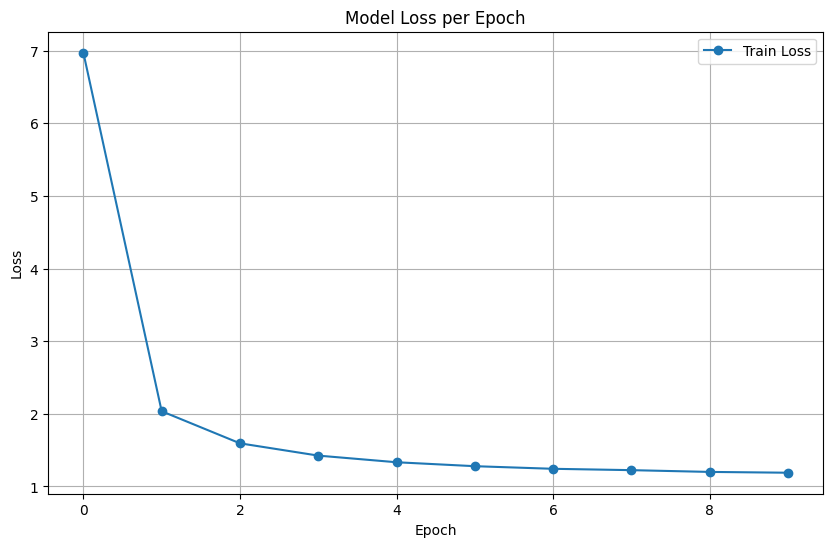

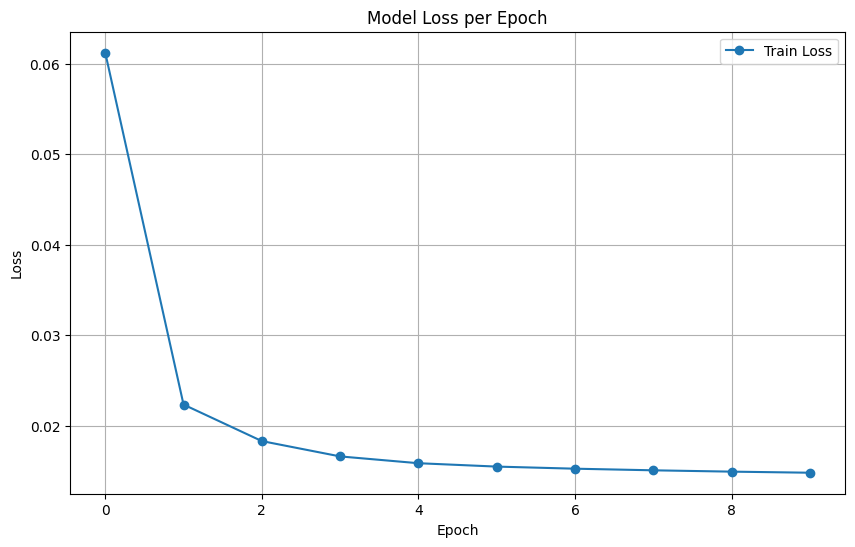

In [ ]:
plot_loss_from_csv('/content/autoencoder_smartwatch_training_log/version_0/metrics.csv')
plot_loss_from_csv('/content/autoencoder_vicon_training_log/version_2/metrics.csv')

# 1D cnn with autoencoder

In [ ]:
class IntegratedCNN1D(pl.LightningModule):
    def __init__(self, pretrained_encoder, num_classes=18):
        super().__init__()
        self.encoder = pretrained_encoder  # Your 50-window encoder
        # We assume the encoder's last layer is Linear(..., latent_dim).
        # So we can fetch out_features to build our classification head:
        flattened_size = pretrained_encoder[-1].out_features

        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        """
        x shape is [batch_size, 3, 3000].
        We'll chunk into 60 segments of length 50, feed each through the encoder,
        and pool their latent vectors before classification.
        """
        # 1) Unfold along dimension=2 (the time dimension),
        #    size=50, step=50 → shape: [batch_size, 3, 60, 50]
        x = x.unfold(dimension=2, size=50, step=50)

        # 2) Rearrange dimensions to [batch_size, 60, 3, 50]
        #    so that each 50-length window is easily processed
        x = x.permute(0, 2, 1, 3)

        # 3) Flatten out (batch_size * 60) windows, shape → [batch_size*60, 3, 50]
        b, w, c, l = x.shape  # w=60 windows
        x = x.reshape(b * w, c, l)

        # 4) Pass each 50-window through the sliding-window encoder
        #    This yields [batch_size*60, latent_dim]
        encoded = self.encoder(x)  # The autoencoder's encoder part

        # 5) Now we have 60 latent vectors per sample. We can pool them
        #    to get a single representation: [batch_size, 60, latent_dim]
        encoded = encoded.reshape(b, w, -1)

        # 6) Pool across the 60 windows. Here we do a simple average
        #    shape → [batch_size, latent_dim]
        encoded = encoded.mean(dim=1)

        # 7) Classification head
        logits = self.fc_layers(encoded)  # shape → [batch_size, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)


In [ ]:
# Initialize the IntegratedCNN1D model
Integrated_smartwatch_model = IntegratedCNN1D(pretrained_encoder=autoencoder_smartwatch, num_classes=18)

# Set up CSVLogger for training logs
Integrated_smartwatch_logger = CSVLogger("/content/", name="Integrated_smartwatch_training_log")

# Define the Trainer
Integrated_smartwatch_trainer = Trainer(max_epochs=MAX_EPOCHS, accelerator='auto', devices=1, logger=logger)

# Train the model
Integrated_smartwatch_trainer.fit(Integrated_smartwatch_model, train_dataloaders=smartwatch_train_loader, val_dataloaders=smartwatch_val_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 8.4 K 
1 | fc_layers | Sequential | 77.5 K
-----------------------------------------
85.9 K    Trainable params
0         Non-trainable params
85.9 K    Total params
0.343     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# Initialize the IntegratedCNN1D model
Integrated_vicon_model = IntegratedCNN1D(pretrained_encoder=autoencoder_vicon.encoder, num_classes=18)

# Set up CSVLogger for training logs
Integrated_vicon_logger = CSVLogger("/content/", name="Integrated_vicon_training_log")

# Define the Trainer
Integrated_vicon_trainer = Trainer(max_epochs=MAX_EPOCHS, accelerator='auto', devices=1, logger=Integrated_vicon_logger)

# Train the model
Integrated_vicon_trainer.fit(Integrated_vicon_model, train_dataloaders=vicon_train_loader, val_dataloaders=vicon_val_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 8.4 K 
1 | fc_layers | Sequential | 77.5 K
-----------------------------------------
85.9 K    Trainable params
0         Non-trainable params
85.9 K    Total params
0.343     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


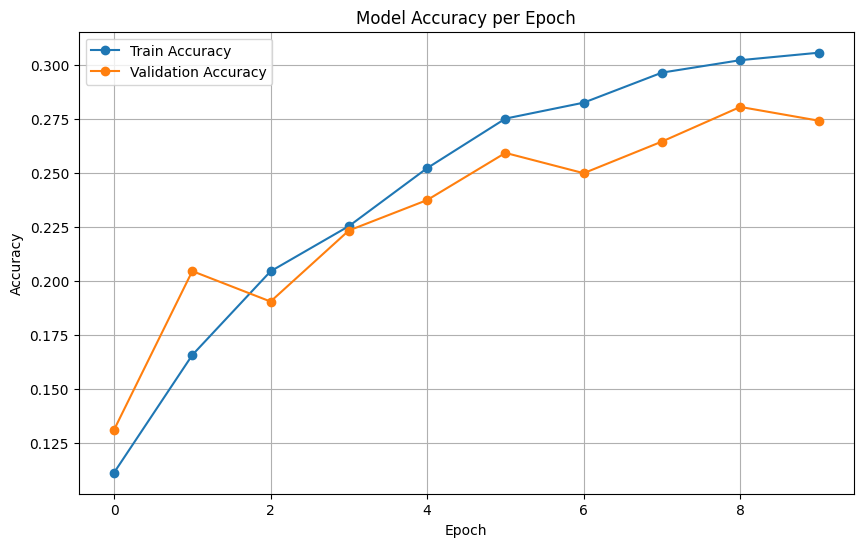

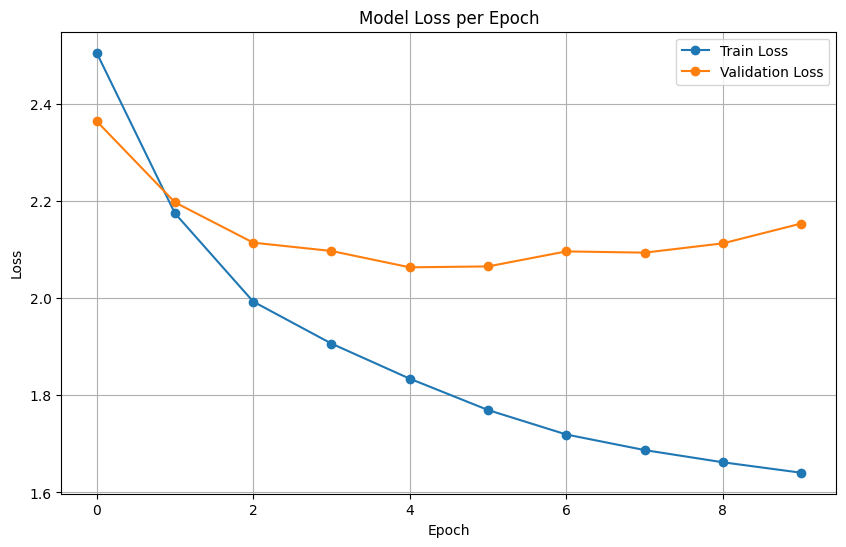

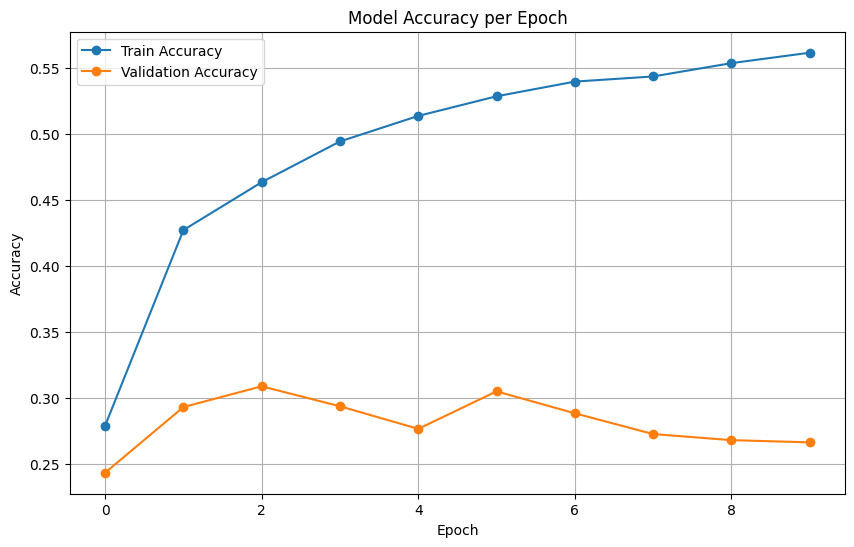

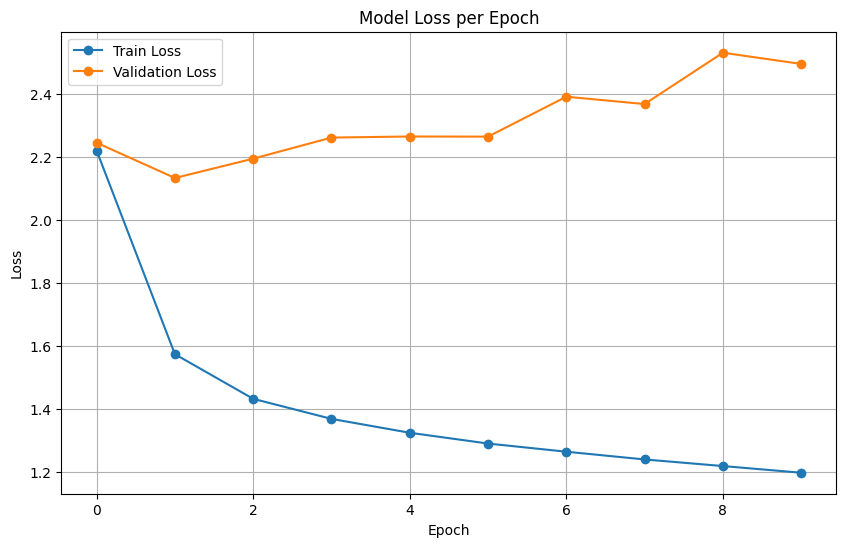

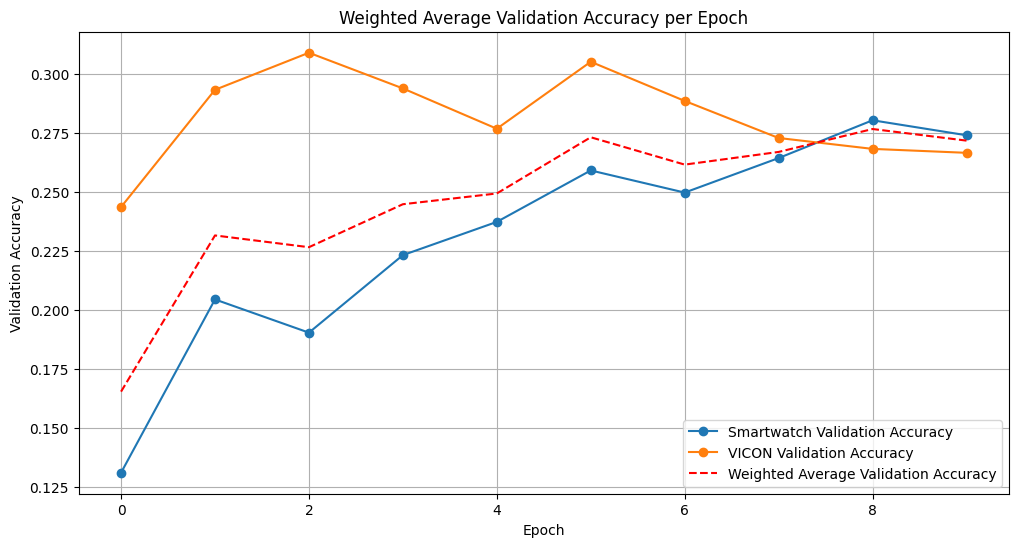

In [ ]:
plot_training_results('/content/Integrated_smartwatch_training_log/version_3/metrics.csv')
plot_training_results('/content/Integrated_vicon_training_log/version_0/metrics.csv')
compare_model_accuracies_with_plot('/content/Integrated_smartwatch_training_log/version_3/metrics.csv', '/content/Integrated_vicon_training_log/version_0/metrics.csv')


# lstm with autoencoder

In [ ]:
class IntegratedLSTM(pl.LightningModule):
    def __init__(self, pretrained_encoder, seq_length=3000, window_size=50, hidden_dim=128, num_layers=2, num_classes=18, bidirectional=False):
        super().__init__()
        self.pretrained_encoder = pretrained_encoder  # autoencoder encoder
        self.seq_length = seq_length
        self.window_size = window_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.bidirectional = bidirectional

        # We'll figure out the autoencoder's latent_dim from the final Linear
        self.latent_dim = pretrained_encoder[-1].out_features

        # Build an LSTM that operates on sequences of latent_dim
        self.lstm = nn.LSTM(
            input_size=self.latent_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.2
        )
        # FC layers after LSTM
        lstm_output_dim = hidden_dim * (2 if bidirectional else 1)
        self.fc_layers = nn.Sequential(
            nn.Linear(lstm_output_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        """
        x shape: [batch_size, 3, seq_length], e.g. [batch_size, 3, 3000].
        We'll chunk into (seq_length/window_size) = 60 windows of size 50,
        pass each through the autoencoder's encoder, and get a sequence
        of latent embeddings for the LSTM.
        """
        # x.unfold(dimension=2, size=window_size, step=window_size) => shape [batch_size, 3, 60, 50]
        x = x.unfold(dimension=2, size=self.window_size, step=self.window_size)

        # Re-arrange to [batch_size, 60, 3, 50]
        x = x.permute(0, 2, 1, 3)

        # Flatten to combine batch & window dims => [batch_size * 60, 3, 50]
        b, w, c, l = x.shape  # w=60 if seq_length=3000
        x = x.reshape(b * w, c, l)

        # Pass each 50-length window through the pretrained encoder
        # -> shape [batch_size * 60, latent_dim]
        encoded = self.pretrained_encoder(x)

        # Reshape back to [batch_size, 60, latent_dim]
        encoded = encoded.reshape(b, w, -1)

        # Now feed this sequence of 60 latent vectors into LSTM
        # shape => [batch_size, 60, latent_dim] -> LSTM => [batch_size, 60, hidden_dim*(2?)]
        lstm_out, _ = self.lstm(encoded)

        # Take the last time-step
        last_out = lstm_out[:, -1, :]  # [batch_size, hidden_dim*(2?)]

        # Finally the FC layers
        logits = self.fc_layers(last_out)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)


In [ ]:
vicon_csv_path = '/content/data_experiment/vicon/train.csv'
smartwatch_csv_path = '/content/data_experiment/smartwatch/train.csv'
vicon_data_dir = '/content/data_experiment/vicon/'
smartwatch_data_dir = '/content/data_experiment/smartwatch/'

BATCH_SIZE = 32
MAX_EPOCHS = 10

# For VICON
vicon_seq_length = 999  # e.g. your dataset min length
vicon_train_loader, vicon_val_loader = create_dataloaders(
    train_csv_path=vicon_csv_path,
    data_dir=vicon_data_dir,
    batch_size=BATCH_SIZE,
    min_length=vicon_seq_length
)

# For Smartwatch
smartwatch_seq_length = 3000
smartwatch_train_loader, smartwatch_val_loader = create_dataloaders(
    train_csv_path=smartwatch_csv_path,
    data_dir=smartwatch_data_dir,
    batch_size=BATCH_SIZE,
    min_length=smartwatch_seq_length
)

In [ ]:
integrated_lstm_vicon = IntegratedLSTM(
    pretrained_encoder=autoencoder_vicon.encoder,
    seq_length=vicon_seq_length,
    window_size=50,
    hidden_dim=128,
    num_layers=2,
    num_classes=18,
    bidirectional=False
)

# VICON training
vicon_logger = CSVLogger(save_dir="/content/", name="Integrated_LSTM_vicon_log")
vicon_trainer = Trainer(max_epochs=MAX_EPOCHS, accelerator='auto', devices=1, logger=vicon_logger)
vicon_trainer.fit(integrated_lstm_vicon, train_dataloaders=vicon_train_loader, val_dataloaders=vicon_val_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type       | Params
--------------------------------------------------
0 | pretrained_encoder | Sequential | 8.4 K 
1 | lstm               | LSTM       | 206 K 
2 | fc_layers          | Sequential | 91.8 K
--------------------------------------------------
307 K     Trainable params
0         Non-trainable params
307 K     Total params
1.228     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
integrated_lstm_smartwatch = IntegratedLSTM(
    pretrained_encoder=autoencoder_smartwatch.encoder,
    seq_length=smartwatch_seq_length,
    window_size=50,
    hidden_dim=128,
    num_layers=2,
    num_classes=18,
    bidirectional=False
)
# Smartwatch training
smartwatch_logger = CSVLogger(save_dir="/content/", name="Integrated_LSTM_smartwatch_log")
smartwatch_trainer = Trainer(max_epochs=MAX_EPOCHS, accelerator='auto', devices=1, logger=smartwatch_logger)
smartwatch_trainer.fit(integrated_lstm_smartwatch, train_dataloaders=smartwatch_train_loader, val_dataloaders=smartwatch_val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type       | Params
--------------------------------------------------
0 | pretrained_encoder | Sequential | 8.4 K 
1 | lstm               | LSTM       | 206 K 
2 | fc_layers          | Sequential | 91.8 K
--------------------------------------------------
307 K     Trainable params
0         Non-trainable params
307 K     Total params
1.228     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


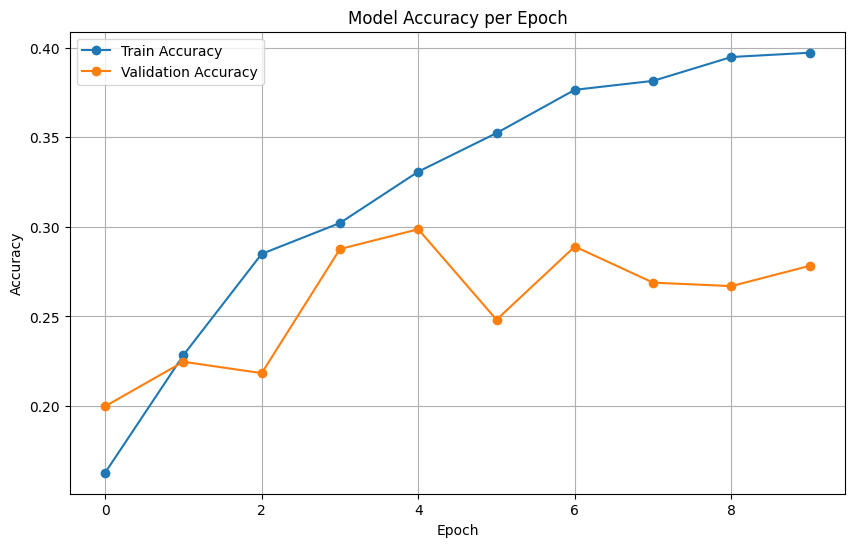

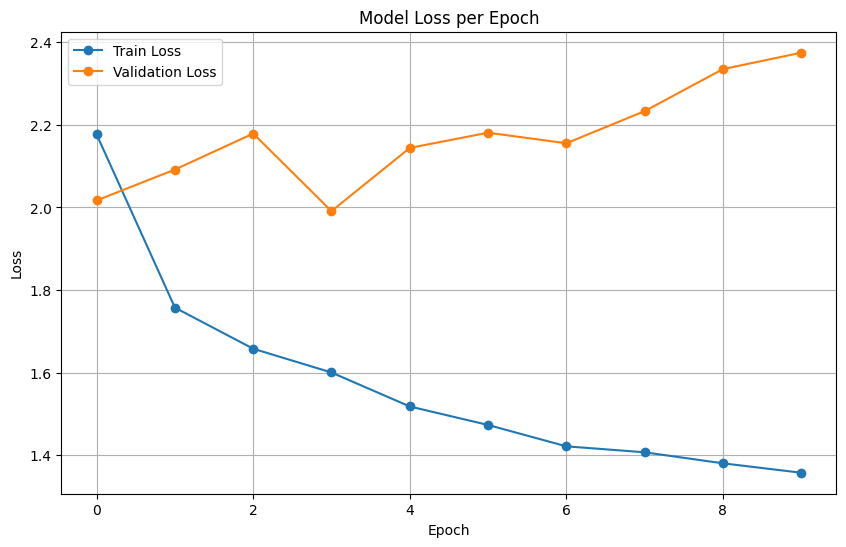

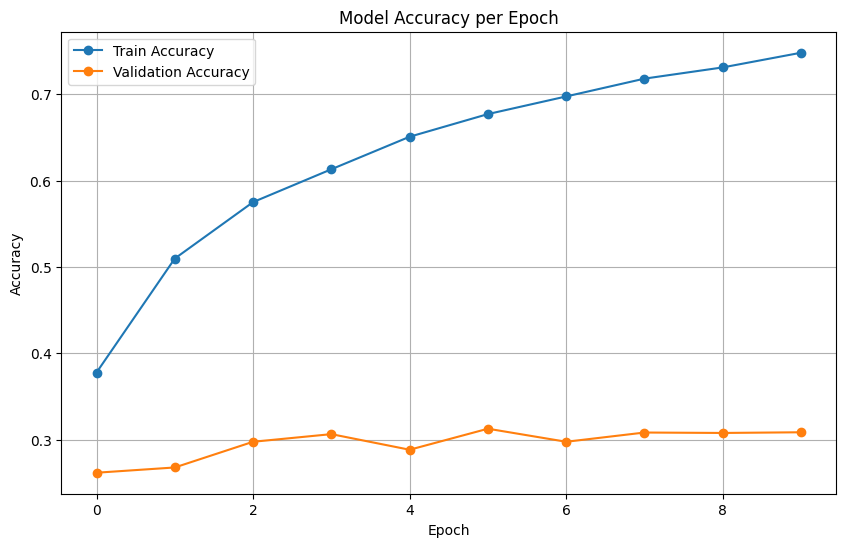

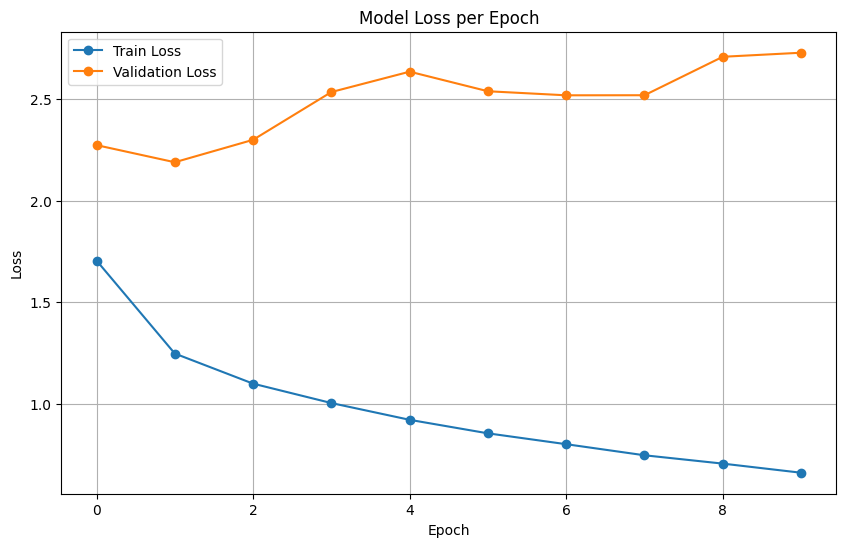

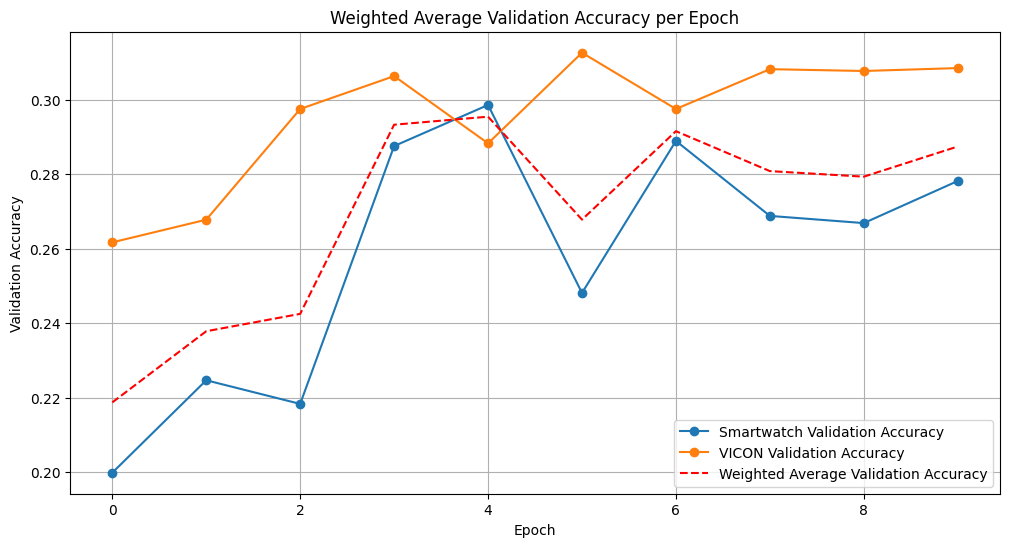

In [ ]:
plot_training_results('/content/Integrated_LSTM_smartwatch_log/version_0/metrics.csv')
plot_training_results('/content/Integrated_LSTM_vicon_log/version_0/metrics.csv')
compare_model_accuracies_with_plot('/content/Integrated_LSTM_smartwatch_log/version_0/metrics.csv', '/content/Integrated_LSTM_vicon_log/version_0/metrics.csv')


#improved 1D cnn

In [ ]:
class Improved1DCNN(pl.LightningModule):
    def __init__(self, input_channels=3, num_classes=18):
        super().__init__()
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=2)
        )

        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=2)
        )

        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=2)
        )

        # Adaptive pooling to handle variable length sequences
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layers with increased size
        self.fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        # Add L2 regularization
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001, weight_decay=1e-4)
        return optimizer


In [ ]:
improved_smartwatch_model = Improved1DCNN(input_channels=3, num_classes=18)

improved_smartwatch_logger = CSVLogger("/content/", name="Improved1DCNN_training")

# Define the Trainer
improved_smartwatch_trainer = Trainer(max_epochs=MAX_EPOCHS, accelerator='auto', devices=1, logger=improved_smartwatch_logger)

# Train the models
improved_smartwatch_trainer.fit(improved_smartwatch_model, train_dataloaders=smartwatch_train_loader, val_dataloaders=smartwatch_val_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | conv1         | Sequential        | 768   
1 | conv2         | Sequential        | 25.0 K
2 | conv3         | Sequential        | 99.1 K
3 | adaptive_pool | AdaptiveAvgPool1d | 0     
4 | fc            | Sequential        | 267 K 
----------------------------------------------------
392 K     Trainable params
0         Non-trainable params
392 K     Total params
1.569     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
improved_vicon_model = Improved1DCNN(input_channels=3, num_classes=18)

improved_vicon_logger = CSVLogger("/content/", name="vicon_Improved1DCNN_training")

# Define the Trainer
improved_vicon_trainer = Trainer(max_epochs=MAX_EPOCHS, accelerator='auto', devices=1, logger=improved_vicon_logger)

# Train the models
improved_vicon_trainer.fit(improved_vicon_model, train_dataloaders=vicon_train_loader, val_dataloaders=vicon_val_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | conv1         | Sequential        | 768   
1 | conv2         | Sequential        | 25.0 K
2 | conv3         | Sequential        | 99.1 K
3 | adaptive_pool | AdaptiveAvgPool1d | 0     
4 | fc            | Sequential        | 267 K 
----------------------------------------------------
392 K     Trainable params
0         Non-trainable params
392 K     Total params
1.569     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


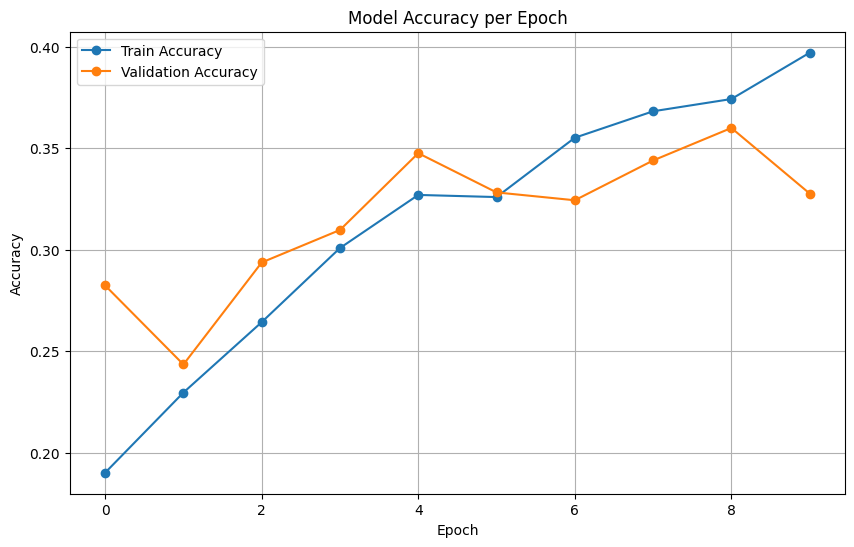

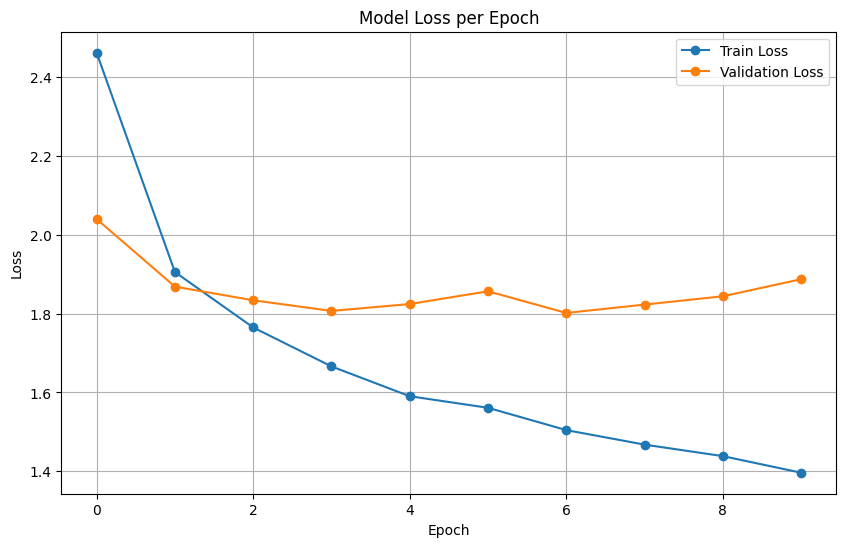

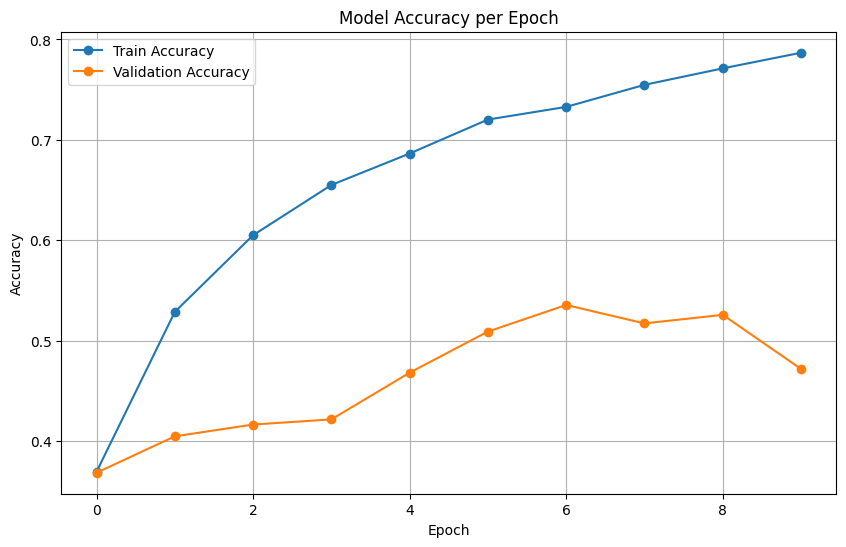

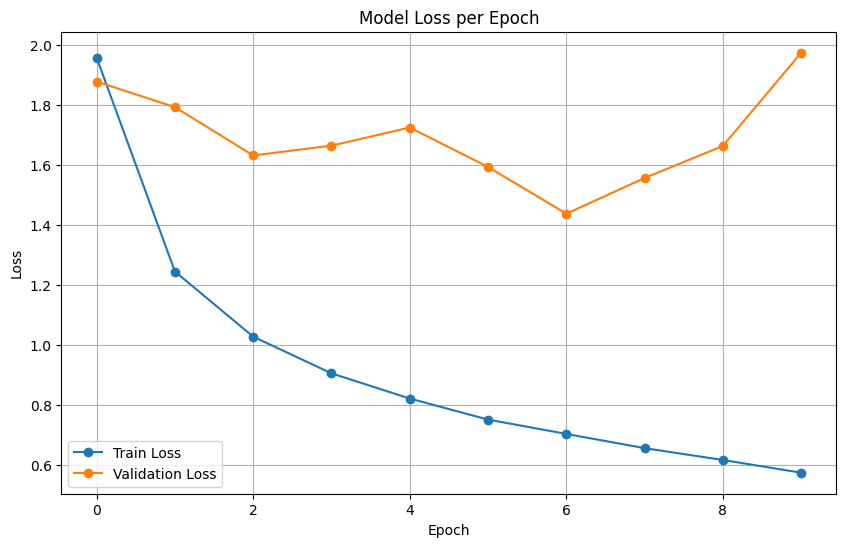

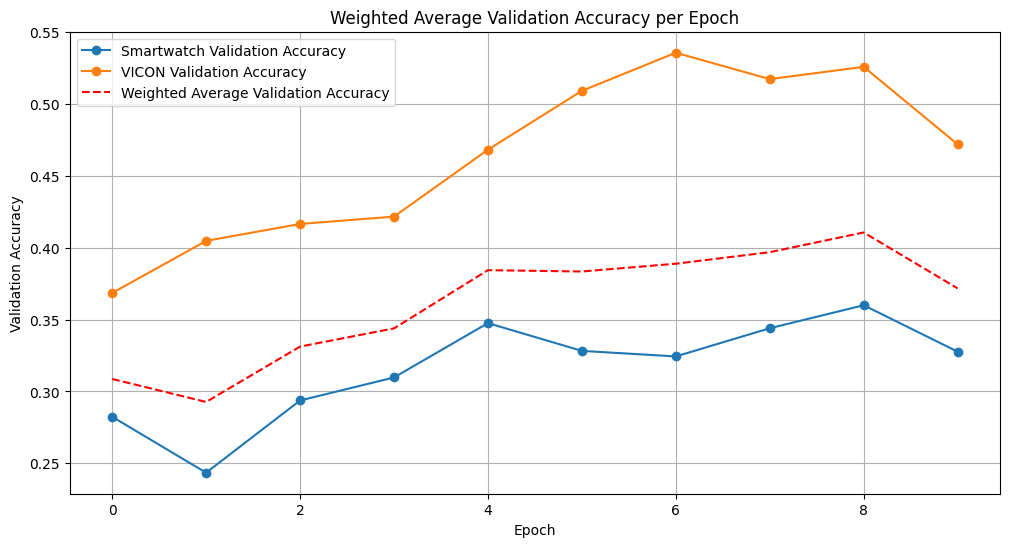

In [ ]:
plot_training_results('/content/Improved1DCNN_training/version_0/metrics.csv') #smartwatch
plot_training_results('/content/vicon_Improved1DCNN_training/version_1/metrics.csv') # vicon
compare_model_accuracies_with_plot('/content/Improved1DCNN_training/version_0/metrics.csv', '/content/vicon_Improved1DCNN_training/version_1/metrics.csv') # smartwatch  vicon


# improved LSTM

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

class ImprovedLSTMModel(pl.LightningModule):
    def __init__(self, min_length, input_dim=3, hidden_dim=128, num_classes=18, num_layers=2, bidirectional=True):
        super().__init__()
        self.min_length = min_length
        self.bidirectional = bidirectional

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.2  # Internal dropout for LSTM
        )

        # Fully connected layers with added complexity and batch normalization
        lstm_output_dim = hidden_dim * (2 if bidirectional else 1)
        self.fc_layers = nn.Sequential(
            nn.Linear(lstm_output_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, num_classes)  # No activation here
        )

    def forward(self, x):
        # LSTM expects input as (batch_size, sequence_length, input_dim)
        x = x.permute(0, 2, 1)  # Reshape from (batch_size, channels, sequence_length) to (batch_size, sequence_length, input_dim)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Take the last time step
        x = self.fc_layers(lstm_out)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optimizer



In [ ]:
improved_smartwatch_model = ImprovedLSTMModel(min_length=smartwatch_min_length, input_dim=3, hidden_dim=128, num_classes=18, num_layers=2, bidirectional=True)

# Example usage
smartwatch_logger = CSVLogger("/content/", name="smartwatch_ImprovedLSTM_training")

# Define the Trainer
smartwatch_trainer = pl.Trainer(logger=smartwatch_logger, max_epochs=10, accelerator='auto')

# Assuming dataloaders are defined
smartwatch_trainer.fit(improved_smartwatch_model, train_dataloaders=smartwatch_train_loader, val_dataloaders=smartwatch_val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params
-----------------------------------------
0 | lstm      | LSTM       | 531 K 
1 | fc_layers | Sequential | 109 K 
-----------------------------------------
640 K     Trainable params
0         Non-trainable params
640 K     Total params
2.562     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
improved_vicon_model = ImprovedLSTMModel(min_length=vicon_min_length, input_dim=3, hidden_dim=128, num_classes=18, num_layers=2, bidirectional=True)
# Example usage
vicon_logger = CSVLogger("/content/", name="vicon_ImprovedLSTM_training")

# Define the Trainer
vicon_trainer = pl.Trainer(logger=vicon_logger, max_epochs=10, accelerator='auto')

# Assuming dataloaders are defined
vicon_trainer.fit(improved_vicon_model, train_dataloaders=vicon_train_loader, val_dataloaders=vicon_val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params
-----------------------------------------
0 | lstm      | LSTM       | 531 K 
1 | fc_layers | Sequential | 109 K 
-----------------------------------------
640 K     Trainable params
0         Non-trainable params
640 K     Total params
2.562     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


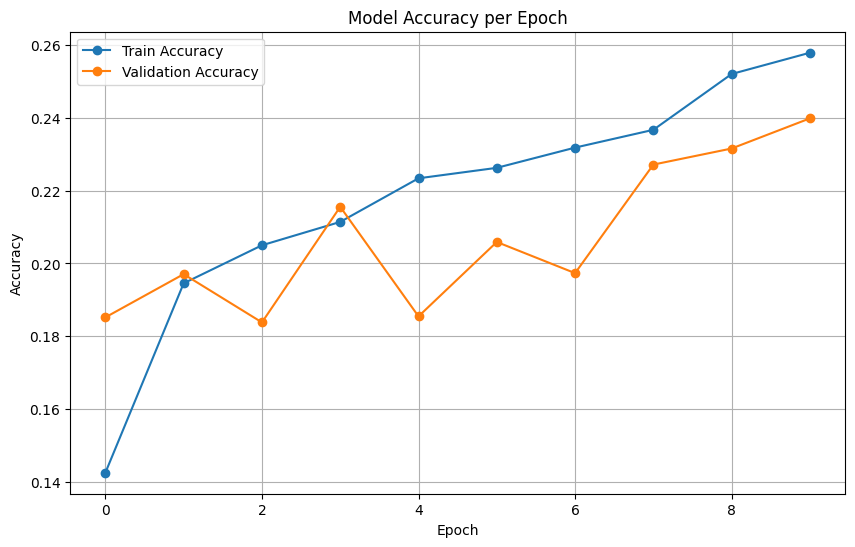

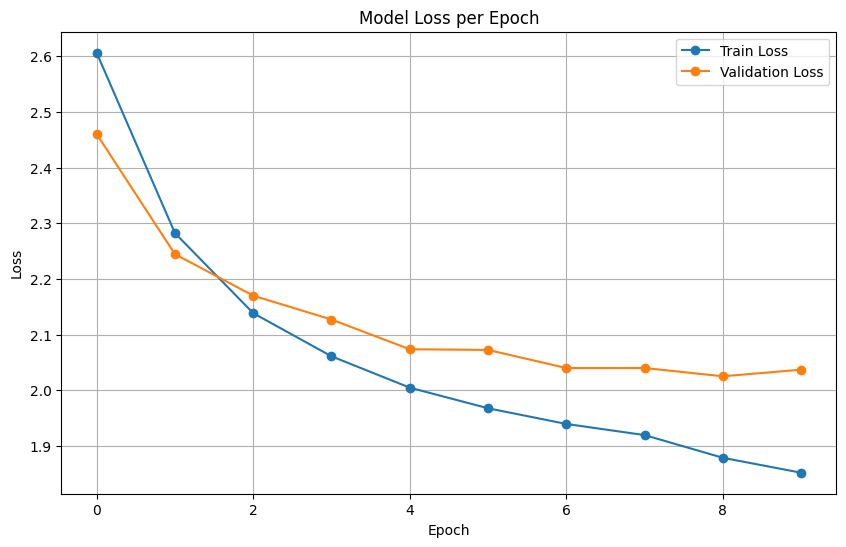

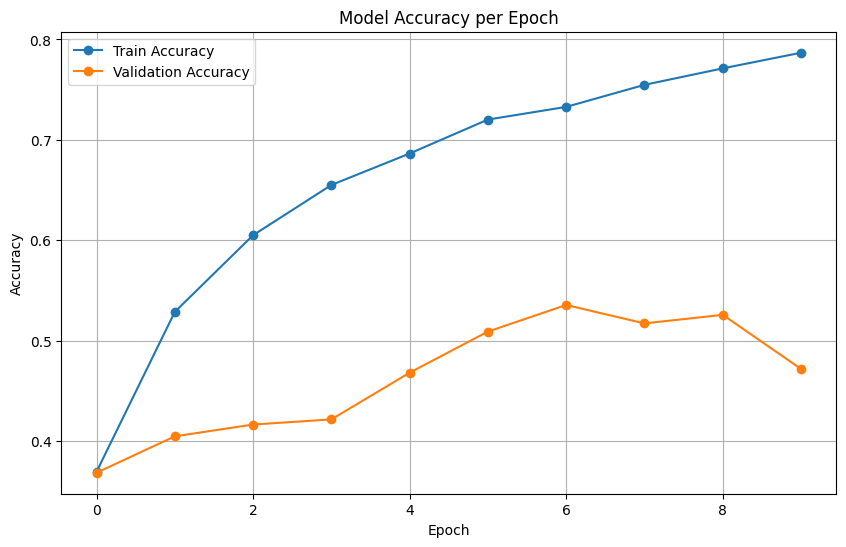

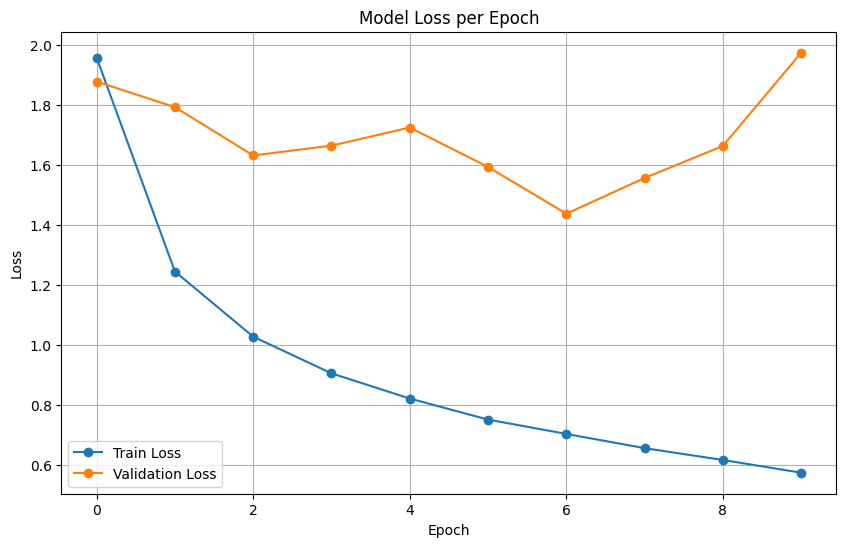

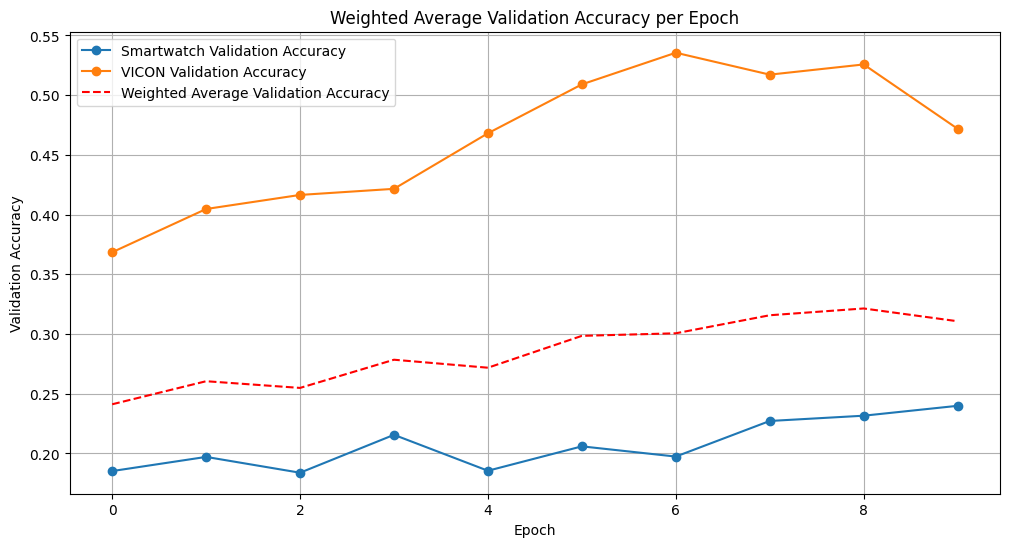

In [ ]:
plot_training_results('/content/smartwatch_ImprovedLSTM_training/version_0/metrics.csv') #smartwatch
plot_training_results('/content/vicon_Improved1DCNN_training/version_1/metrics.csv') # vicon
compare_model_accuracies_with_plot('/content/smartwatch_ImprovedLSTM_training/version_0/metrics.csv', '/content/vicon_Improved1DCNN_training/version_1/metrics.csv') # smartwatch  vicon
